<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Analyse de Trajectoires de Tracking</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p, li {
            font-size: 16px;
        }
        .green-text{
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Analyse de Trajectoires de Tracking</h1>
    <p>Ce code d'analyse permet de traiter les données issues du tracking pour extraire et étudier statistiquement les trajectoires pertinentes. Le processus est structuré comme suit :</p>
    <ol>
        <li><strong class="green-text">Récupération des trajectoires :</strong> Collecte de toutes les trajectoires issues des différentes manipulations.</li>
        <li><strong class="green-text">Pré-analyse :</strong> Examen initial des trajectoires pour déterminer celles à conserver pour l'analyse approfondie.</li>
        <li><strong class="green-text">Analyse statistique :</strong> Application de méthodes statistiques aux trajectoires conservées. Les données peuvent être séparées en deux populations pour un traitement spécifique si nécessaire.</li>
    </ol>
    <p>L'analyse se concentre sur les paramètres suivants :</p>
    <ul>
        <li>Angle entre les directions successives d'une particule entre chaque intervalle de temps.</li>
        <li>Vitesses moyennes et instantanées des particules.</li>
        <li>Variation de la vitesse en fonction du temps d'incubation.</li>
        <li>Effet potentiel de la densité de cellules sur la motilité.</li>
    </ul>
</body>
</html>


##
<center><span style="color: seagreen; font-size: 50px; font-style: bold">Chargement et préparation des données.</span></center>
<span style="color: skyblue; font-size: 20px; font-style: bold">Chargement des librairies.</span>

In [102]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  1 12:46:56 2023.

@author: souchaud
"""

import os
import time
import math
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from cycler import cycler
import trackpy as tp
import functions_analyze as lib
import warnings
import importlib
from colorama import init
from typing import List, Optional, Union, Any, Dict, Tuple
from scipy.stats import linregress
import seaborn as sns


# Reload custom library
importlib.reload(lib)

# Initialize colorama
init(autoreset=True)

# Suppress specific warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

# Set default matplotlib style
plt.style.use('default')

<span style="color: skyblue; font-size: 20px; font-style: bold">Paramètres de graphs.</span>

In [103]:
plt.rcParams.update({
    # Figure
    "figure.figsize": (10, 6),  # Taille par défaut de la figure (largeur, hauteur en pouces)
    "figure.dpi": 100,  # Résolution en points par pouce
    "figure.facecolor": (0, 0, 0, 1),  # Fond de la figure : noir pur
    "figure.edgecolor": "white",  # Bordure de la figure en blanc
    "figure.titlesize": 20,  # Taille de la police pour le titre principal
    "figure.titleweight": "bold",  # Style de la police pour le titre principal : gras

    # Axes
    "axes.facecolor": (0, 0, 0, 1),  # Fond des axes : noir pur
    "axes.edgecolor": "white",  # Bordure des axes en blanc
    "axes.linewidth": 2,  # Épaisseur des bordures des axes
    "axes.titlesize": 16,  # Taille de la police des titres des axes
    "axes.titleweight": "bold",  # Style de la police pour les titres des axes : gras
    "axes.labelsize": 14,  # Taille de la police des étiquettes des axes
    "axes.labelweight": "medium",  # Style de la police des étiquettes : intermédiaire
    "axes.labelcolor": "white",  # Couleur des étiquettes des axes
    "axes.prop_cycle": cycler(color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]),  # Cycle des couleurs pour les lignes
    "axes.grid": True,  # Activer la grille
    "axes.grid.axis": "both",  # Grille pour les deux axes (x et y)
    "axes.grid.which": "major",  # Grille pour les ticks principaux
    "grid.color": "gray",  # Couleur des lignes de la grille
    "grid.linewidth": 0.5,  # Épaisseur des lignes de la grille
    "grid.alpha": 0.6,  # Transparence des lignes de la grille

    # Ticks (Graduations)
    "xtick.color": "white",  # Couleur des ticks sur l'axe x
    "ytick.color": "white",  # Couleur des ticks sur l'axe y
    "xtick.labelsize": 16,  # Taille de la police des ticks sur l'axe x
    "ytick.labelsize": 16,  # Taille de la police des ticks sur l'axe y
    "xtick.direction": "in",  # Ticks pointant vers l'intérieur sur l'axe x
    "ytick.direction": "in",  # Ticks pointant vers l'intérieur sur l'axe y
    "xtick.major.size": 8,  # Longueur des ticks principaux sur l'axe x
    "ytick.major.size": 8,  # Longueur des ticks principaux sur l'axe y
    "xtick.minor.size": 4,  # Longueur des ticks secondaires sur l'axe x
    "ytick.minor.size": 4,  # Longueur des ticks secondaires sur l'axe y
    "xtick.major.width": 1.5,  # Épaisseur des ticks principaux sur l'axe x
    "ytick.major.width": 1.5,  # Épaisseur des ticks principaux sur l'axe y

    # Lignes et marqueurs
    # "lines.linewidth": 2,  # Épaisseur par défaut des lignes
    # "lines.linestyle": "-",  # Style par défaut des lignes continues
    # "lines.color": "#1f77b4",  # Couleur par défaut des lignes
    # "lines.marker": "o",  # Marqueur par défaut : cercle
    # "lines.markersize": 8,  # Taille par défaut des marqueurs
    # "lines.markeredgewidth": 1.5,  # Épaisseur du bord des marqueurs
    # "lines.markerfacecolor": "blue",  # Couleur du remplissage des marqueurs

    # Polices
    "font.size": 12,  # Taille globale de la police
    "font.family": "sans-serif",  # Famille de polices par défaut
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],  # Liste des polices sans-serif préférées
    "text.color": "white",  # Couleur du texte

    # Légendes
    "legend.loc": "upper right",  # Emplacement par défaut de la légende
    "legend.fontsize": 12,  # Taille de la police pour la légende
    "legend.frameon": True,  # Activer le cadre autour de la légende
    "legend.framealpha": 0.8,  # Transparence du cadre de la légende
    "legend.edgecolor": "white",  # Couleur de la bordure de la légende
    "legend.facecolor": (0.2, 0.2, 0.2, 0.9),  # Fond de la légende : gris foncé semi-transparent

    # Sauvegarde des graphiques
    "savefig.dpi": 300,  # Résolution par défaut pour les fichiers sauvegardés
    "savefig.format": "png",  # Format par défaut pour les fichiers sauvegardés
    "savefig.facecolor": (0, 0, 0, 1),  # Fond des figures sauvegardées : noir pur
    "savefig.edgecolor": "none",  # Pas de bordure pour les figures sauvegardées
    "savefig.transparent": True,  # Fond transparent pour les fichiers sauvegardés

    # Couleurs et cycles
    "image.cmap": "viridis",  # Palette par défaut pour les images
})

##
<span style="color: skyblue; font-size: 20px; font-style: bold">Initialisation des variables et constantes de travail..</span>

In [104]:
# Set initial time
INITIAL_TIME = time.time()

# Experiment parameters
TIME_FRAME = 15
SIZE_PIX = 0.637
FPS = 1 / TIME_FRAME

# File to study
file_name = 'filtered_final'
N_FRAME_MIN_STUDY = 200

# Study parameters
ROLLING_MEAN = False
PIXELISATION = False
TIME_FRAME_STUDY = False
DRIFT = False

# Plot parameters
IMG_TYPE = 'png'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)

##
<span style="color: skyblue; font-size: 20px; font-style: bold">Définition des path et dossiers de travails / enregistrements.</span>

<span style="color: skyblue; font-size: 20px; font-style: bold">Conditions des manips étudiées.</span>

<span style="color: skyblue; font-size: 20px; font-style: bold">Défintions et créations des différents dossiers d'enregistrements.</span>

In [146]:
# General paths
GENERAL_PATH = '/Users/souchaud/Desktop/Analyses/'
GENERAL_PATH_PICTURES = '/Users/souchaud/Desktop/A_analyser/'

# Condition
CONDITION_simple = 'CytoOne_HL5_AMPC_10x'
CONDITION = f'{CONDITION_simple}_results_tracking'

# Définition du chemin complet
CONDITION_PATH = os.path.join(GENERAL_PATH, CONDITION)

# Liste des noms à filtrer
names = ["ASMOT240", "ASMOT241"]  # Remplace par ta liste

# Get list of experiments, en filtrant par les noms contenus dans `names`
PATHWAY_EXPERIMENT = [os.path.join(CONDITION_PATH, f, 'mosaic')
                      for f in os.listdir(CONDITION_PATH)
                      if os.path.isdir(os.path.join(CONDITION_PATH, f)) and any(name in f for name in names)]

# Path to save pictures
path_save_pic = os.path.join(GENERAL_PATH, f'résultats_{CONDITION}_All')

# Create directory if it doesn't exist
os.makedirs(path_save_pic, exist_ok=True)
os.chdir(path_save_pic)


In [147]:
PATHWAY_EXPERIMENT

['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_AMPC_10x_results_tracking/2025_01_17_ASMOT241_AX3_MAT_P3_10x_CytoOne_HL5_0114-10h40-0117-15h30-PBS/mosaic',
 '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_AMPC_10x_results_tracking/2025_01_17_ASMOT240_AX3_MAT_P3_10x_CytoOne_HL5_0114-10h40-0117-14h00-PBS-45min-nature/mosaic']

<span style="color: skyblue; font-size: 20px; font-style: bold">Ajout des temps d'incubation.</span>

In [148]:
# Add incubation times to DATA
conditions_to_values = {
    'ASMOT240': 75.33, 'ASMOT241': 76.83,

}
experiment_to_dell= {
    'ASMOT232', 'ASMOT233', 'ASMOT234', 'ASMOT235', 'ASMOT236', 'ASMOT237', 'ASMOT238', 'ASMOT239',
    'ASMOT242', 'ASMOT243', 'ASMOT244', 'ASMOT245', 'ASMOT246', 'ASMOT247',
    'ASMOT248', 'ASMOT249', 'ASMOT250',
}


##
<center><span style="color: Crimson; font-size: 30px; font-style: bold">Lecture des données expériementales.</span></center>

<span style="color: skyblue; font-size: 20px">On décide de travailler que sur un certain nombre de frame. Ici je décide de travailler sur les 340 première frames pour normaliser les expériences. 
Donc la cellules doit être suivi sur N_MIN_STUDY sur les 340 premières frames. </span>

<span style="color: skyblue; font-size: 20px">Application de fonctions pour moyenne flissante et pixelisation et étude d'une frame sur x </span>

In [153]:
# Read HDF5 data
importlib.reload(lib)
DATA = lib.read_hdf5_all(
    pathway_experiment=PATHWAY_EXPERIMENT,
    name_file=file_name,
    nbr_frame_min=N_FRAME_MIN_STUDY,
    condition=CONDITION,
    drift=DRIFT,
    search_range=20,
    memory=5
)
# Sort DATA by 'frame'
DATA.sort_values(by='frame', inplace=True)

# Filter DATA
print("Nombre de particules avant tri: ", DATA['particle'].nunique())
DATA = DATA[DATA['frame'] < 340]

# Keep particles with sufficient frames
DATA = DATA.groupby('particle').filter(lambda x: len(x) >= N_FRAME_MIN_STUDY)
print("Nombre de particules après tri: ", DATA['particle'].nunique())

# Apply optional data transformations
if ROLLING_MEAN:
    DATA = lib.rolling_mean(datas=DATA, roll=3)
if PIXELISATION:
    DATA = lib.pixelisation(datas=DATA, size_pix=SIZE_PIX)
if TIME_FRAME_STUDY:
    DATA, TIME_FRAME = lib.keep_nth_image(traj=DATA, n=N_FRAME_MIN_STUDY, time_frame=TIME_FRAME)

# Calculate instant velocities
DATA['time (min)'] = DATA['frame'] * TIME_FRAME / 60
DATA = lib.vit_instant_new(traj=DATA, lag_time=TIME_FRAME, pix_size=SIZE_PIX, triage=1)

DATA['time to incubation (hours)'] = DATA['experiment'].map(conditions_to_values).fillna(0.0)

data_240 = DATA[DATA['experiment'] == 'ASMOT240']
data_241 = DATA[DATA['experiment'] == 'ASMOT241']

['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_AMPC_10x_results_tracking/2025_01_17_ASMOT241_AX3_MAT_P3_10x_CytoOne_HL5_0114-10h40-0117-15h30-PBS/mosaic/filtered_final.hdf5']
ASMOT241  :  37
['/Users/souchaud/Desktop/Analyses/CytoOne_HL5_AMPC_10x_results_tracking/2025_01_17_ASMOT240_AX3_MAT_P3_10x_CytoOne_HL5_0114-10h40-0117-14h00-PBS-45min-nature/mosaic/filtered_final.hdf5']
ASMOT240  :  38
Nombre de particules récoltées avant tri:  75
Nombre de particules avant tri:  75
Nombre de particules après tri:  75


###
<center><span style="color: skyblue; font-size: 20px"> Mean Mass and size plot </span></center>

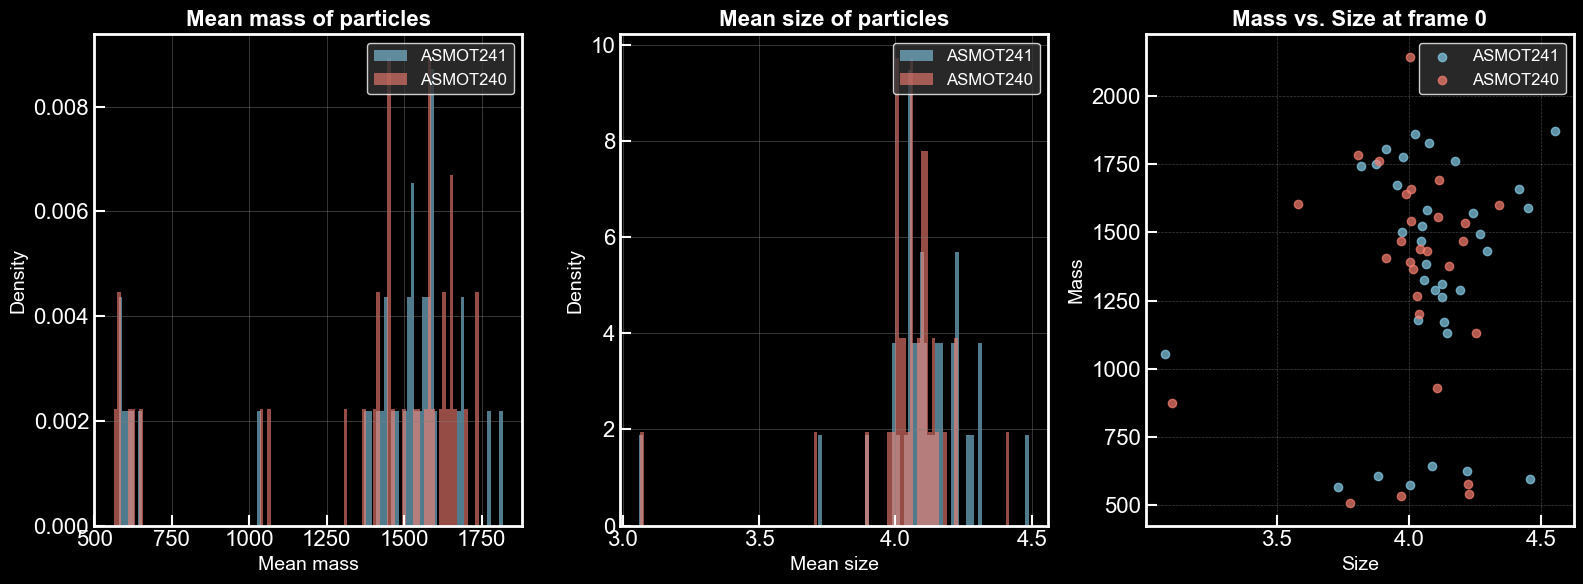

In [155]:
# Plot Mean Mass and Size per Manipulation
# Définition de la fonction pour tracer les résultats des deux expériences sur les mêmes graphes
def plot_mean_mass_size_combined(DATA, path_save_pic, IMG_TYPE):
    manips = DATA['experiment'].unique()
    colors = ['skyblue', 'salmon']  # Couleurs pour différencier les expériences

    fig = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 3, fig)

    # Création des axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    for i, manip in enumerate(manips):
        data_manip = DATA[DATA['experiment'] == manip]
        mass_means = data_manip.groupby('particle')['mass'].mean()
        size_means = data_manip.groupby('particle')['size'].mean()
        filtered_data = data_manip[data_manip['frame'] == 0]

        # Histogramme des masses moyennes
        ax1.hist(mass_means, bins=100, color=colors[i], alpha=0.6, density=True, label=manip)

        # Histogramme des tailles moyennes
        ax2.hist(size_means, bins=100, color=colors[i], alpha=0.6, density=True, label=manip)

        # Scatter plot masse vs taille
        ax3.scatter(filtered_data['size'], filtered_data['mass'], c=colors[i], edgecolors=colors[i], alpha=0.7, label=manip)

    # Personnalisation des axes
    ax1.set_title("Mean mass of particles")
    ax1.set_xlabel("Mean mass")
    ax1.set_ylabel("Density")
    ax1.legend()

    ax2.set_title("Mean size of particles")
    ax2.set_xlabel("Mean size")
    ax2.set_ylabel("Density")
    ax2.legend()

    ax3.set_title("Mass vs. Size at frame 0")
    ax3.set_xlabel("Size")
    ax3.set_ylabel("Mass")
    ax3.legend()
    ax3.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Sauvegarde du graphique
    fig.savefig(os.path.join(path_save_pic, f"Mean_Mass_Size_combined.{IMG_TYPE}"), format=IMG_TYPE)

plot_mean_mass_size_combined(DATA, path_save_pic, IMG_TYPE='svg')


###
<center><span style="color: skyblue; font-size: 20px"> plot total path for each partciel in each experiment (histograms) </span></center>

In [156]:
# Calculate total path for the first N frames
path_data = lib.calculate_total_path_first_frames(DATA, first_n_frames=100)

###
<center><span style="color: skyblue; font-size: 20px"> Creation des traj centrées / distance cumulée / IMSD </span></center>


In [157]:
# Center trajectories
DATA.reset_index(inplace=True)
DATA = lib.center(traj=DATA)

print(f"\n\nTemps de préparation des données pour {CONDITION}: {time.time() - INITIAL_TIME} sec\n\n")

# Calculate total and cumulative displacement
DATA, start_end = lib.length_displacement(traj=DATA, size_pix=SIZE_PIX)

# Compute MSD and cutoff
DATA2 = DATA.copy()
DATA2['frame'] = pd.factorize(DATA2['frame'])[0]
IMSD = tp.imsd(traj=DATA2, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')



Temps de préparation des données pour CytoOne_HL5_AMPC_10x_results_tracking: 13561.893323898315 sec




###
<center><span style="color: skyblue; font-size: 20px"> Premier fit pour exclure certaines traj </span></center>

# negative slope 1


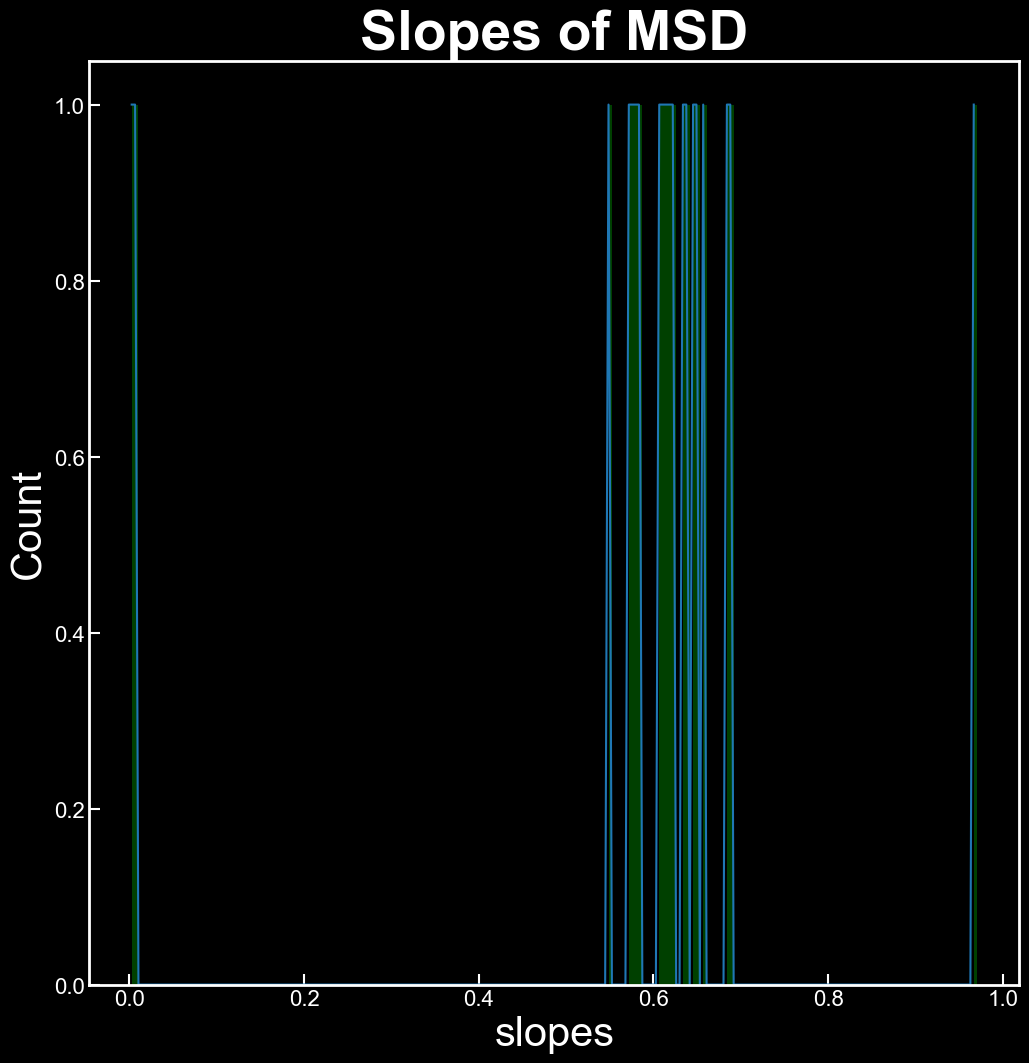

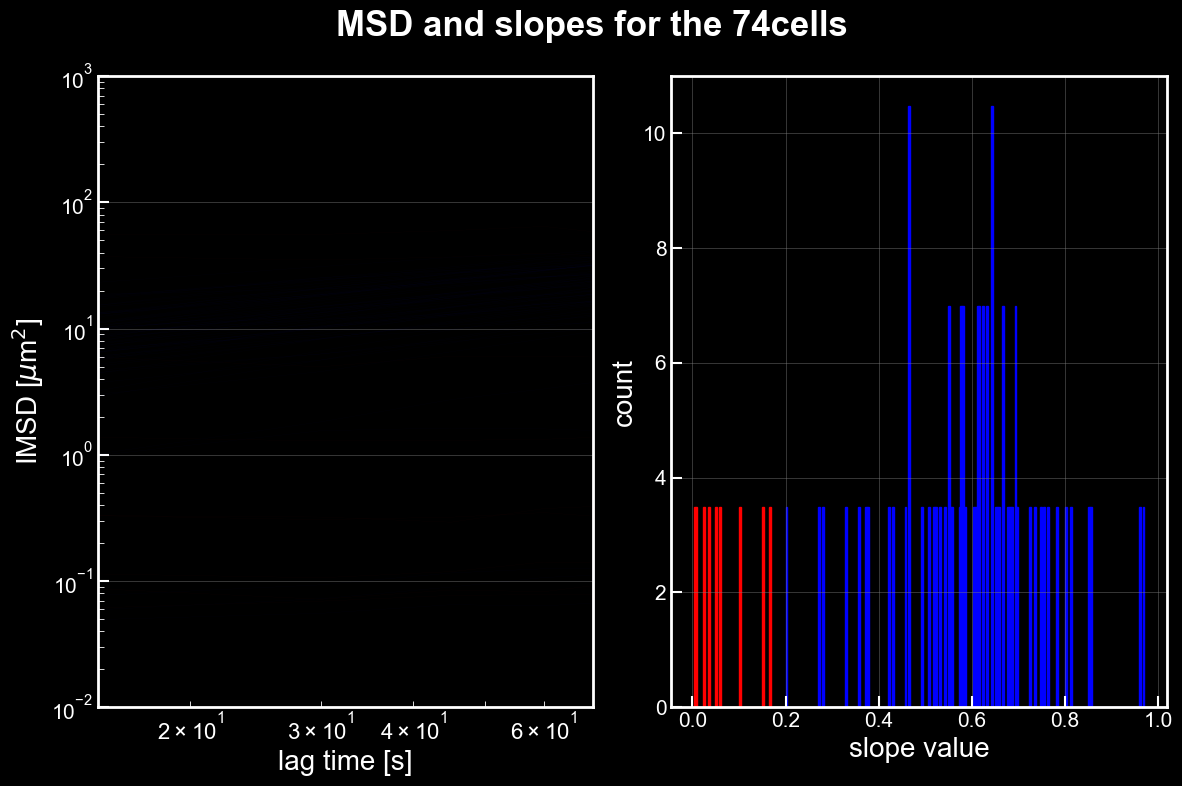

In [158]:
# Trajectory clustering with fit and defining a cutoff
LAG_TIME_FIT = 5
importlib.reload(lib)
COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF = lib.traj_clustering_with_fit_cutoff(
    DATA2, imsd=IMSD, hist=True, lag_time_fit=LAG_TIME_FIT, micronperpixel=SIZE_PIX,
    fps=FPS, binsize=250, peak_height=50, peak_width=1, save=True, pathway_fig=path_save_pic,
    name='all_experiment_autocorr', img_type=IMG_TYPE, plot=True, color_sup_inf=color_sup_inf,
    cutoff_default=0.20
)

# Keep only particles above cutoff
DATA = DATA[DATA['particle'].isin(PART_COEF_SUP)]

###
<center><span style="color: skyblue; font-size: 20px"> Nombre de particules par frame pour les expériences. </span></center>

ça n'a pas un grand interêt ici, mais c'est par principe pour vérification et compréhension d'éventuels phenomènes.

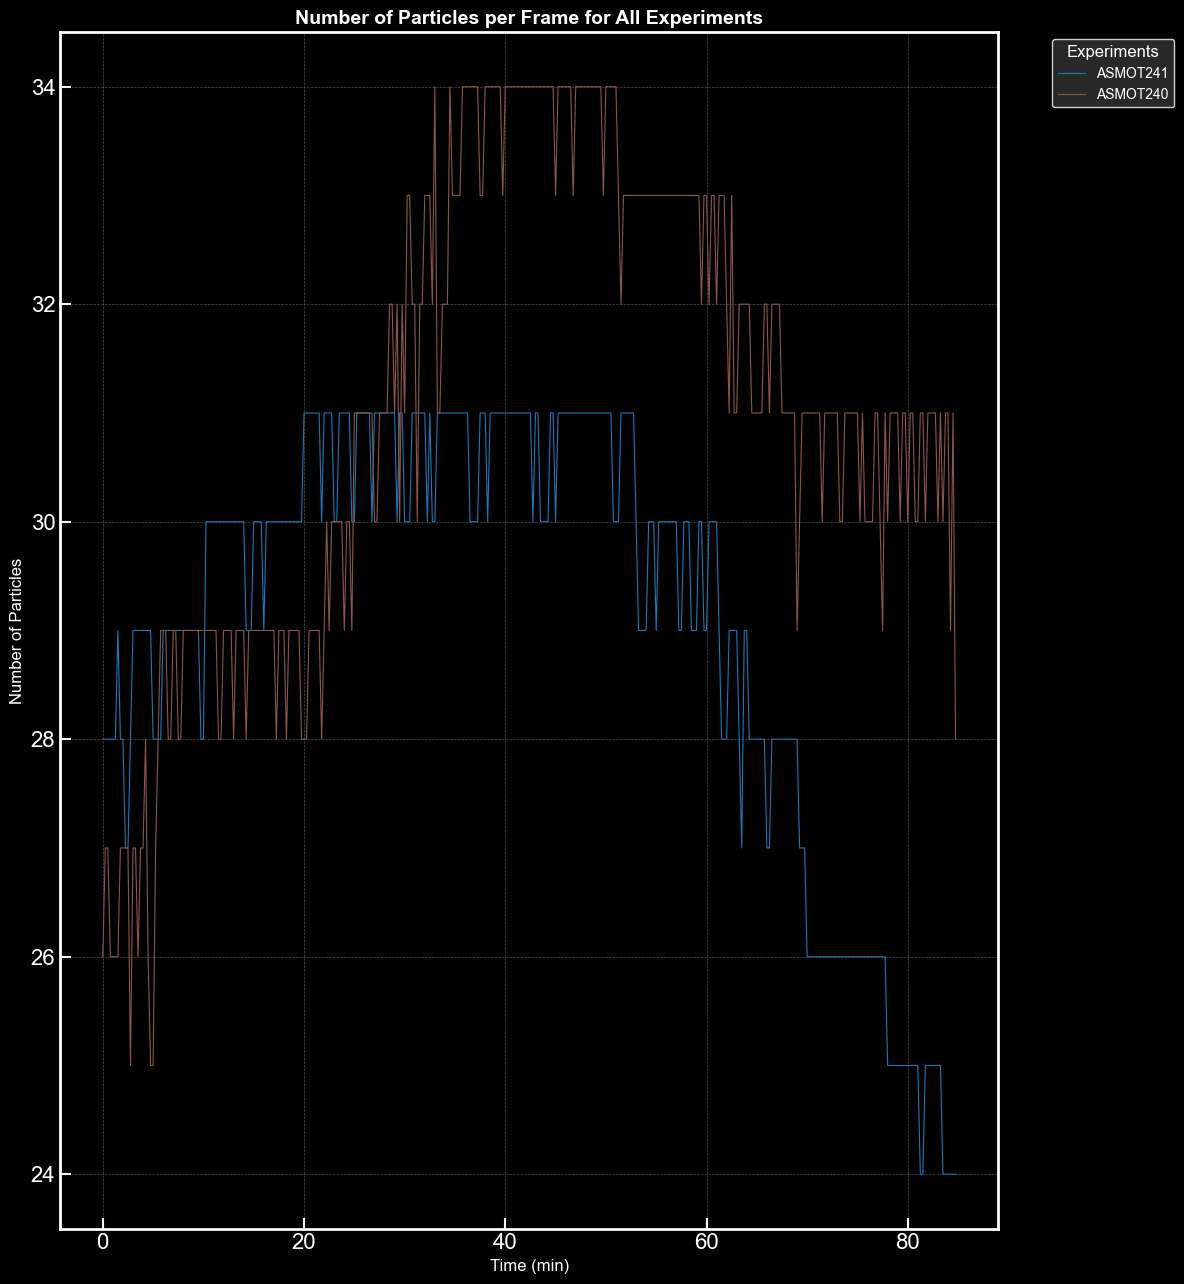

Plot saved to /Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_AMPC_10x_results_tracking_All/Nbr_particle_per_Frame_combined.png


In [113]:
# Plot Number of Particles per Frame for All Experiments in One Graph
def plot_nbr_particles_per_frame_combined(DATA, path_save_pic, IMG_TYPE):
    """
    Plot the number of unique particles per frame for all experiments on a single graph with different colors.

    Parameters:
    - DATA (DataFrame): The input data containing tracking information.
    - path_save_pic (str): The path where the plot will be saved.
    - IMG_TYPE (str): The format for saving the plot (e.g., 'png', 'jpg').
    """
    experiments = DATA['experiment'].unique()

    # Generate a colormap with enough unique colors for all experiments
    colormap = plt.colormaps['tab20']  # Use the modern colormap API
    colors = [colormap(i / len(experiments)) for i in range(len(experiments))]

    plt.figure(figsize=(12, 13))
    for i, exp in enumerate(experiments):
        # Group data by time and calculate the number of unique particles per frame
        nbr_part_per_frame = DATA[DATA['experiment'] == exp].groupby('time (min)')['particle'].nunique()
        plt.plot(
            nbr_part_per_frame.index, nbr_part_per_frame.values, 
            label=exp, color=colors[i], alpha=1, linewidth=0.8
        )

    # Add labels, legend, and title
    plt.title('Number of Particles per Frame for All Experiments', fontsize=14)
    plt.xlabel('Time (min)', fontsize=12)
    plt.ylabel('Number of Particles', fontsize=12)
    plt.legend(title="Experiments", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save and show the plot
    fig_path = os.path.join(path_save_pic, f"Nbr_particle_per_Frame_combined.{IMG_TYPE}")
    plt.savefig(fig_path, format=IMG_TYPE, bbox_inches='tight')
    plt.show()

    print(f"Plot saved to {fig_path}")

# Appel de la fonction
plot_nbr_particles_per_frame_combined(DATA, path_save_pic, IMG_TYPE)

###
<center><span style="color: skyblue; font-size: 20px"> Nombre de particules par frame pour toutes les paticules. </span></center>


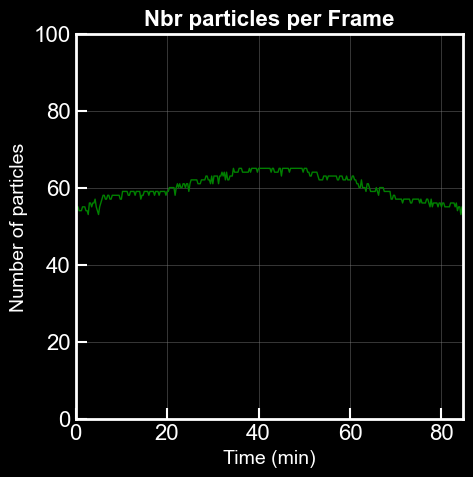

Figure saved at: /Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_AMPC_10x_results_tracking_All/Nbr_particles_per_Frame.png


In [114]:
# Plot Number of Particles per Frame
nbr_part_per_frame = DATA.groupby('time (min)')['particle'].nunique()
lib.plot_datas(
    x_values=nbr_part_per_frame.index,
    y_values=nbr_part_per_frame.values,
    title='Nbr particles per Frame',
    x_label='Time (min)', y_label='Number of particles',
    x_lim=[0, nbr_part_per_frame.index.max()], y_lim=[0, 100],
    save=True, path_save_pic=path_save_pic, img_type=IMG_TYPE
)

###
<center><span style="color: skyblue; font-size: 40px">Trajectoires toutes rassemblées. </span></center>


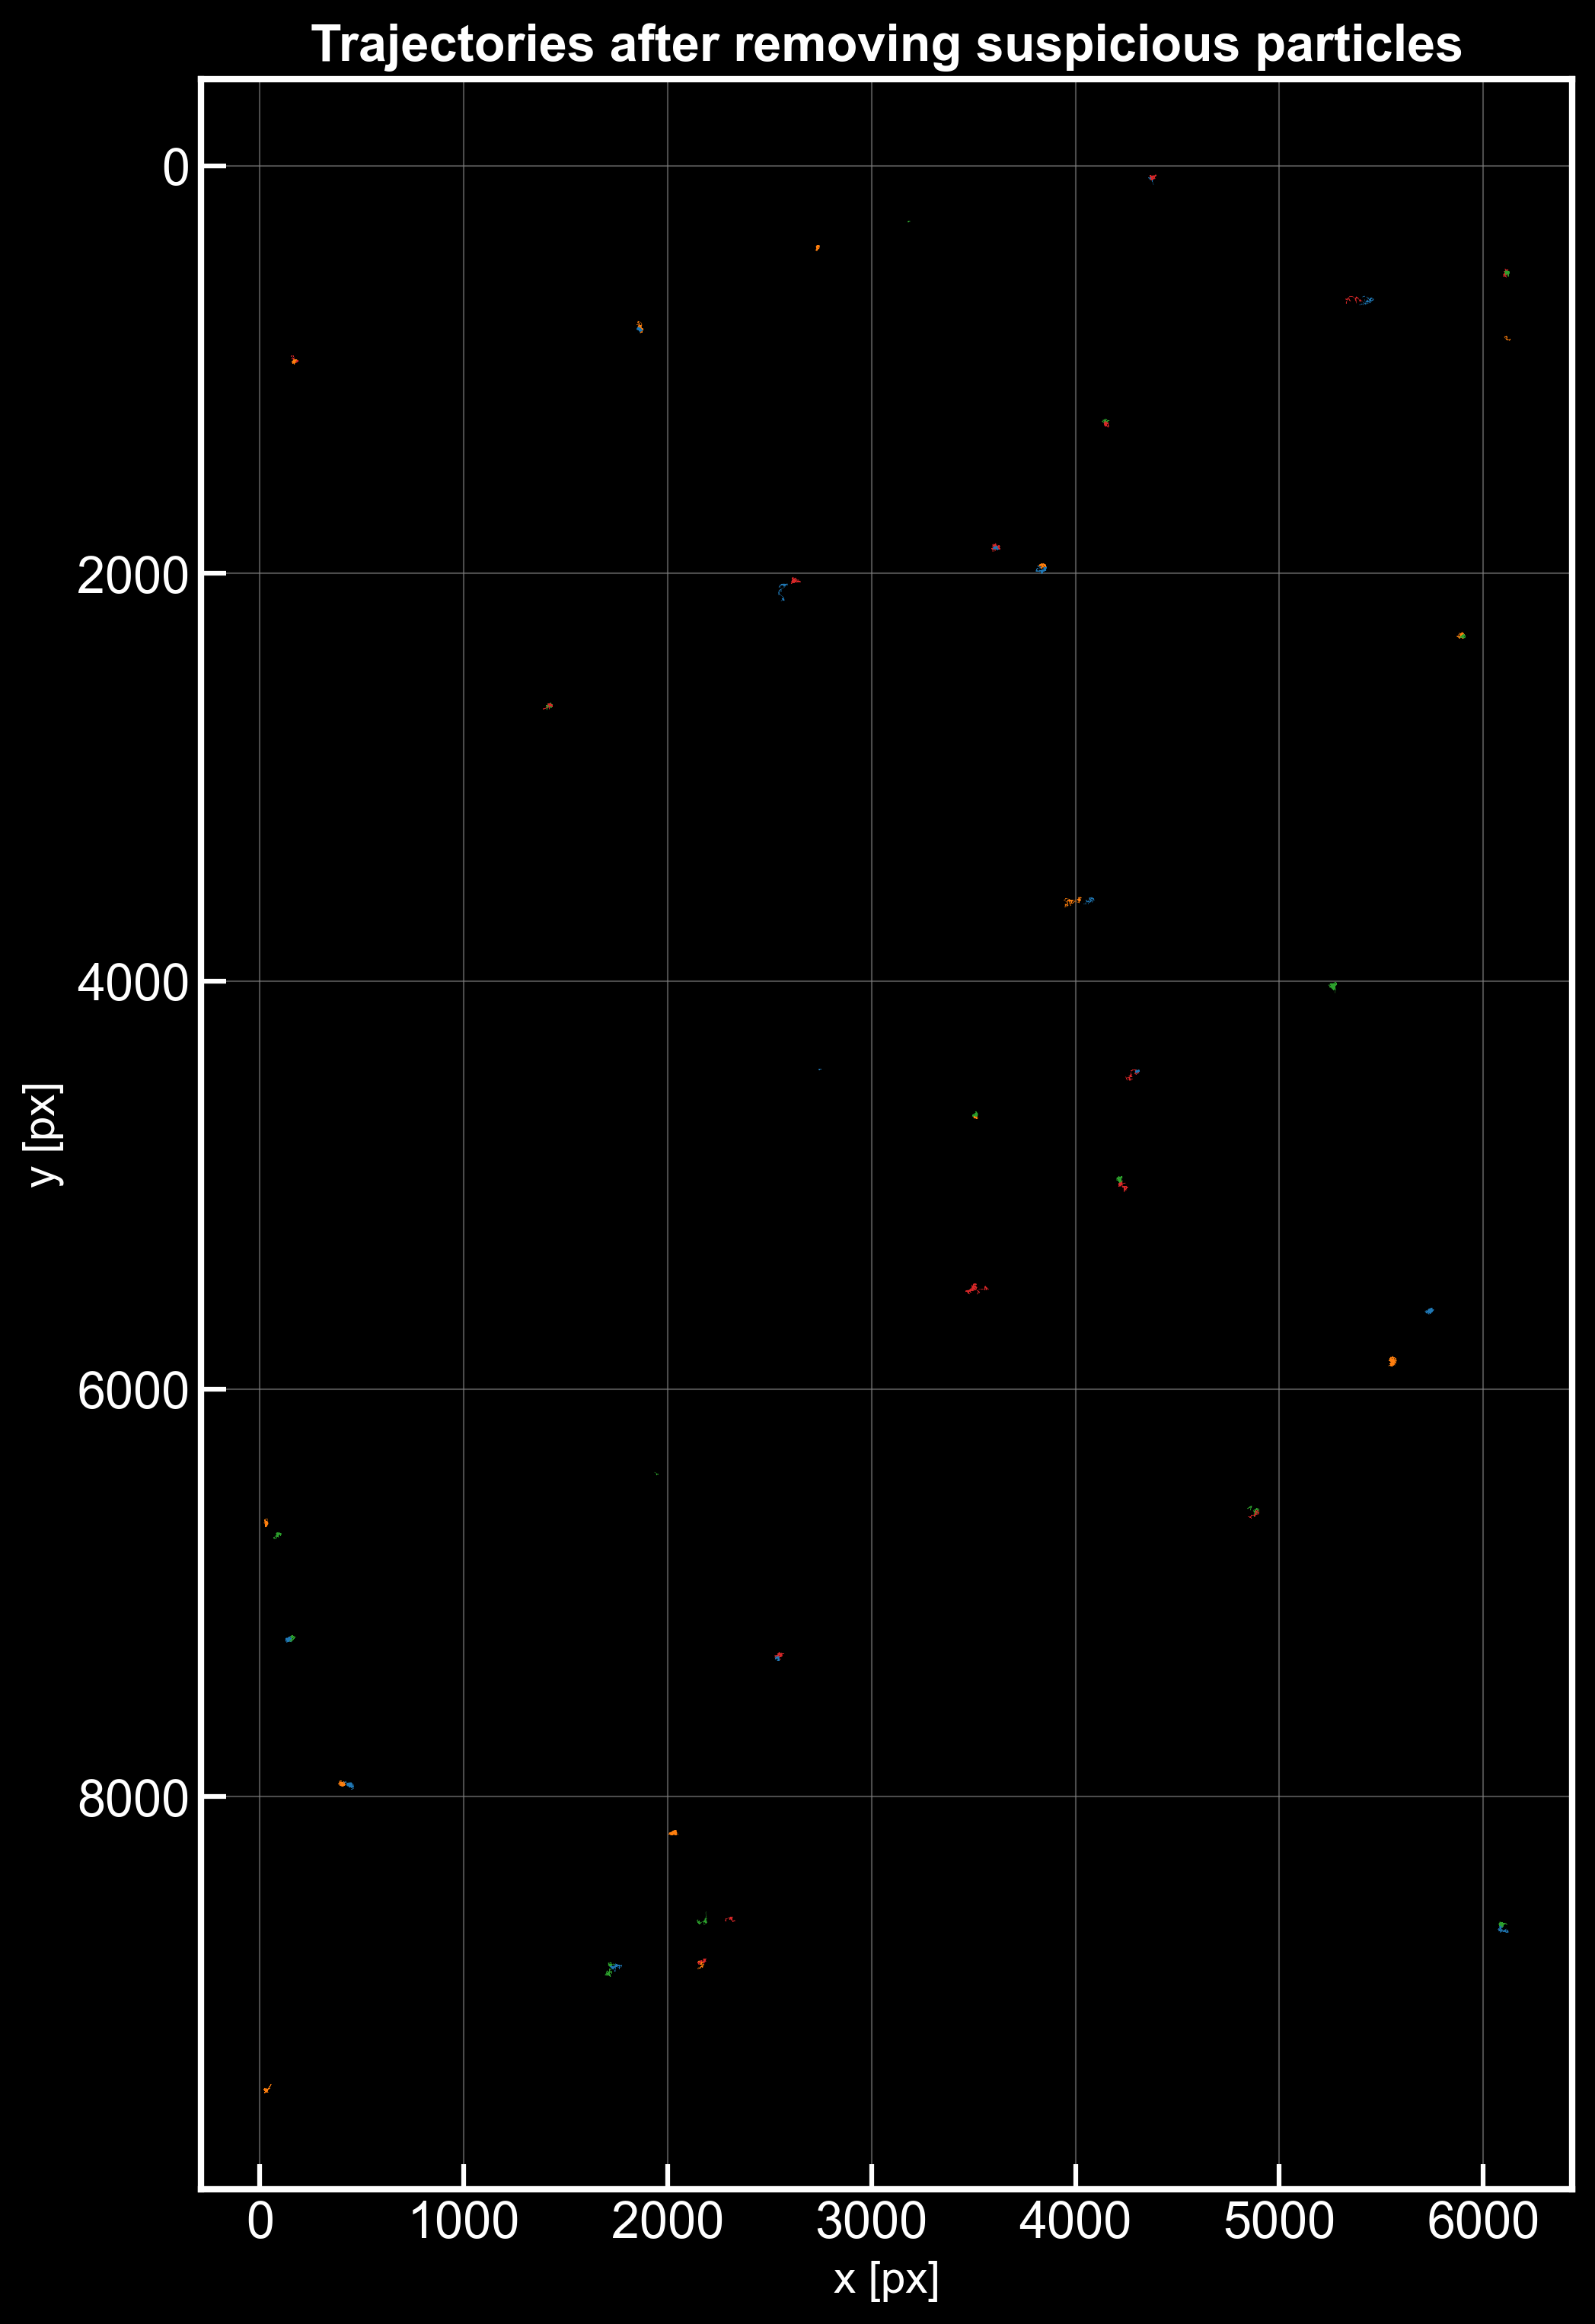

In [115]:
# Plot Trajectories after Removing Suspicious Particles
fig, axis = plt.subplots(figsize=(12, 12), dpi=300)
axis.set_aspect('equal', 'box')
plt.title('Trajectories after removing suspicious particles', fontsize=16)
tp.plot_traj(DATA, label=False, ax=axis)
for line in axis.get_lines():
    line.set_linewidth(0.1)
plt.show()
fig.savefig(os.path.join(path_save_pic, f'Trajectories_after_removing_suspicious_particles.{IMG_TYPE}'),
            format=IMG_TYPE, dpi=300, bbox_inches='tight')

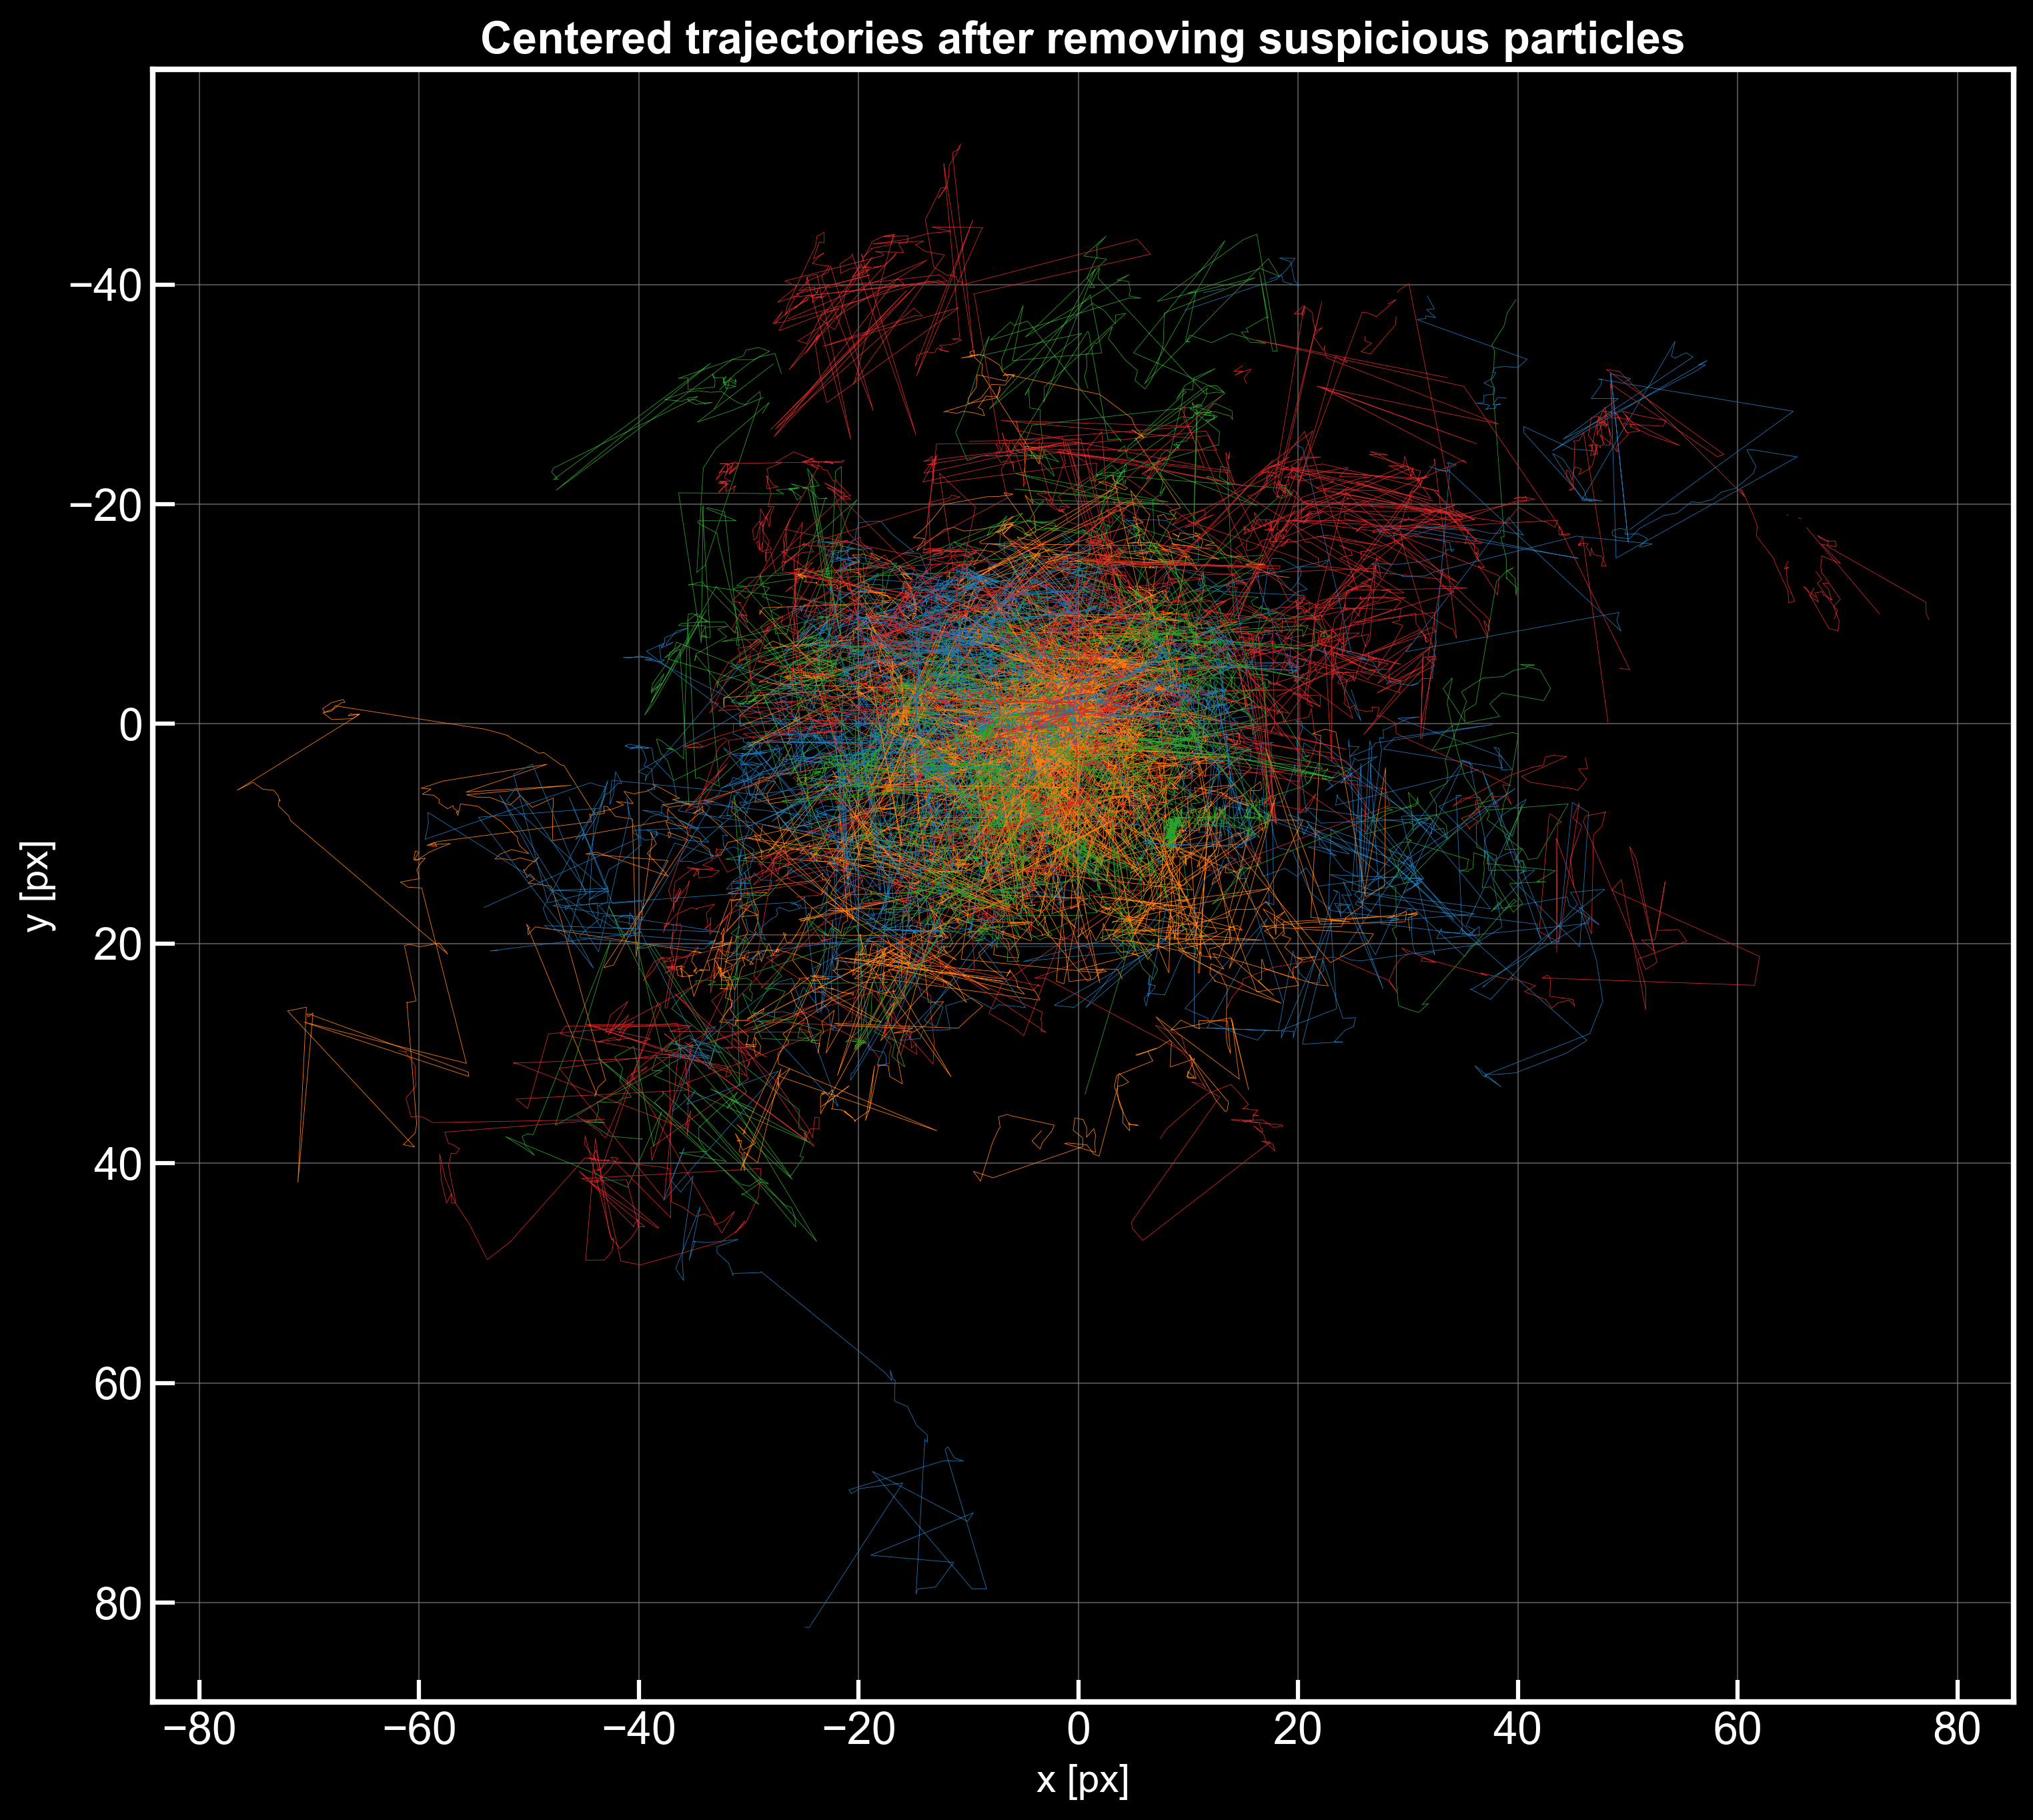

In [116]:
# Plot centered Trajectories after Removing Suspicious Particles
fig, axis = plt.subplots(figsize=(12, 12), dpi=300)
axis.set_aspect('equal', 'box')
plt.title('Centered trajectories after removing suspicious particles', fontsize=16)
tp.plot_traj(DATA[['Xc [pix]', 'Yc [pix]', 'frame', 'particle']].rename(columns={'Xc [pix]': 'x', 'Yc [pix]': 'y'}), label=False, ax=axis)
for line in axis.get_lines():
    line.set_linewidth(0.2)
plt.show()
fig.savefig(os.path.join(path_save_pic, f'Centered trajectories_after_removing_suspicious_particles.{IMG_TYPE}'),
            format=IMG_TYPE, dpi=300, bbox_inches='tight')

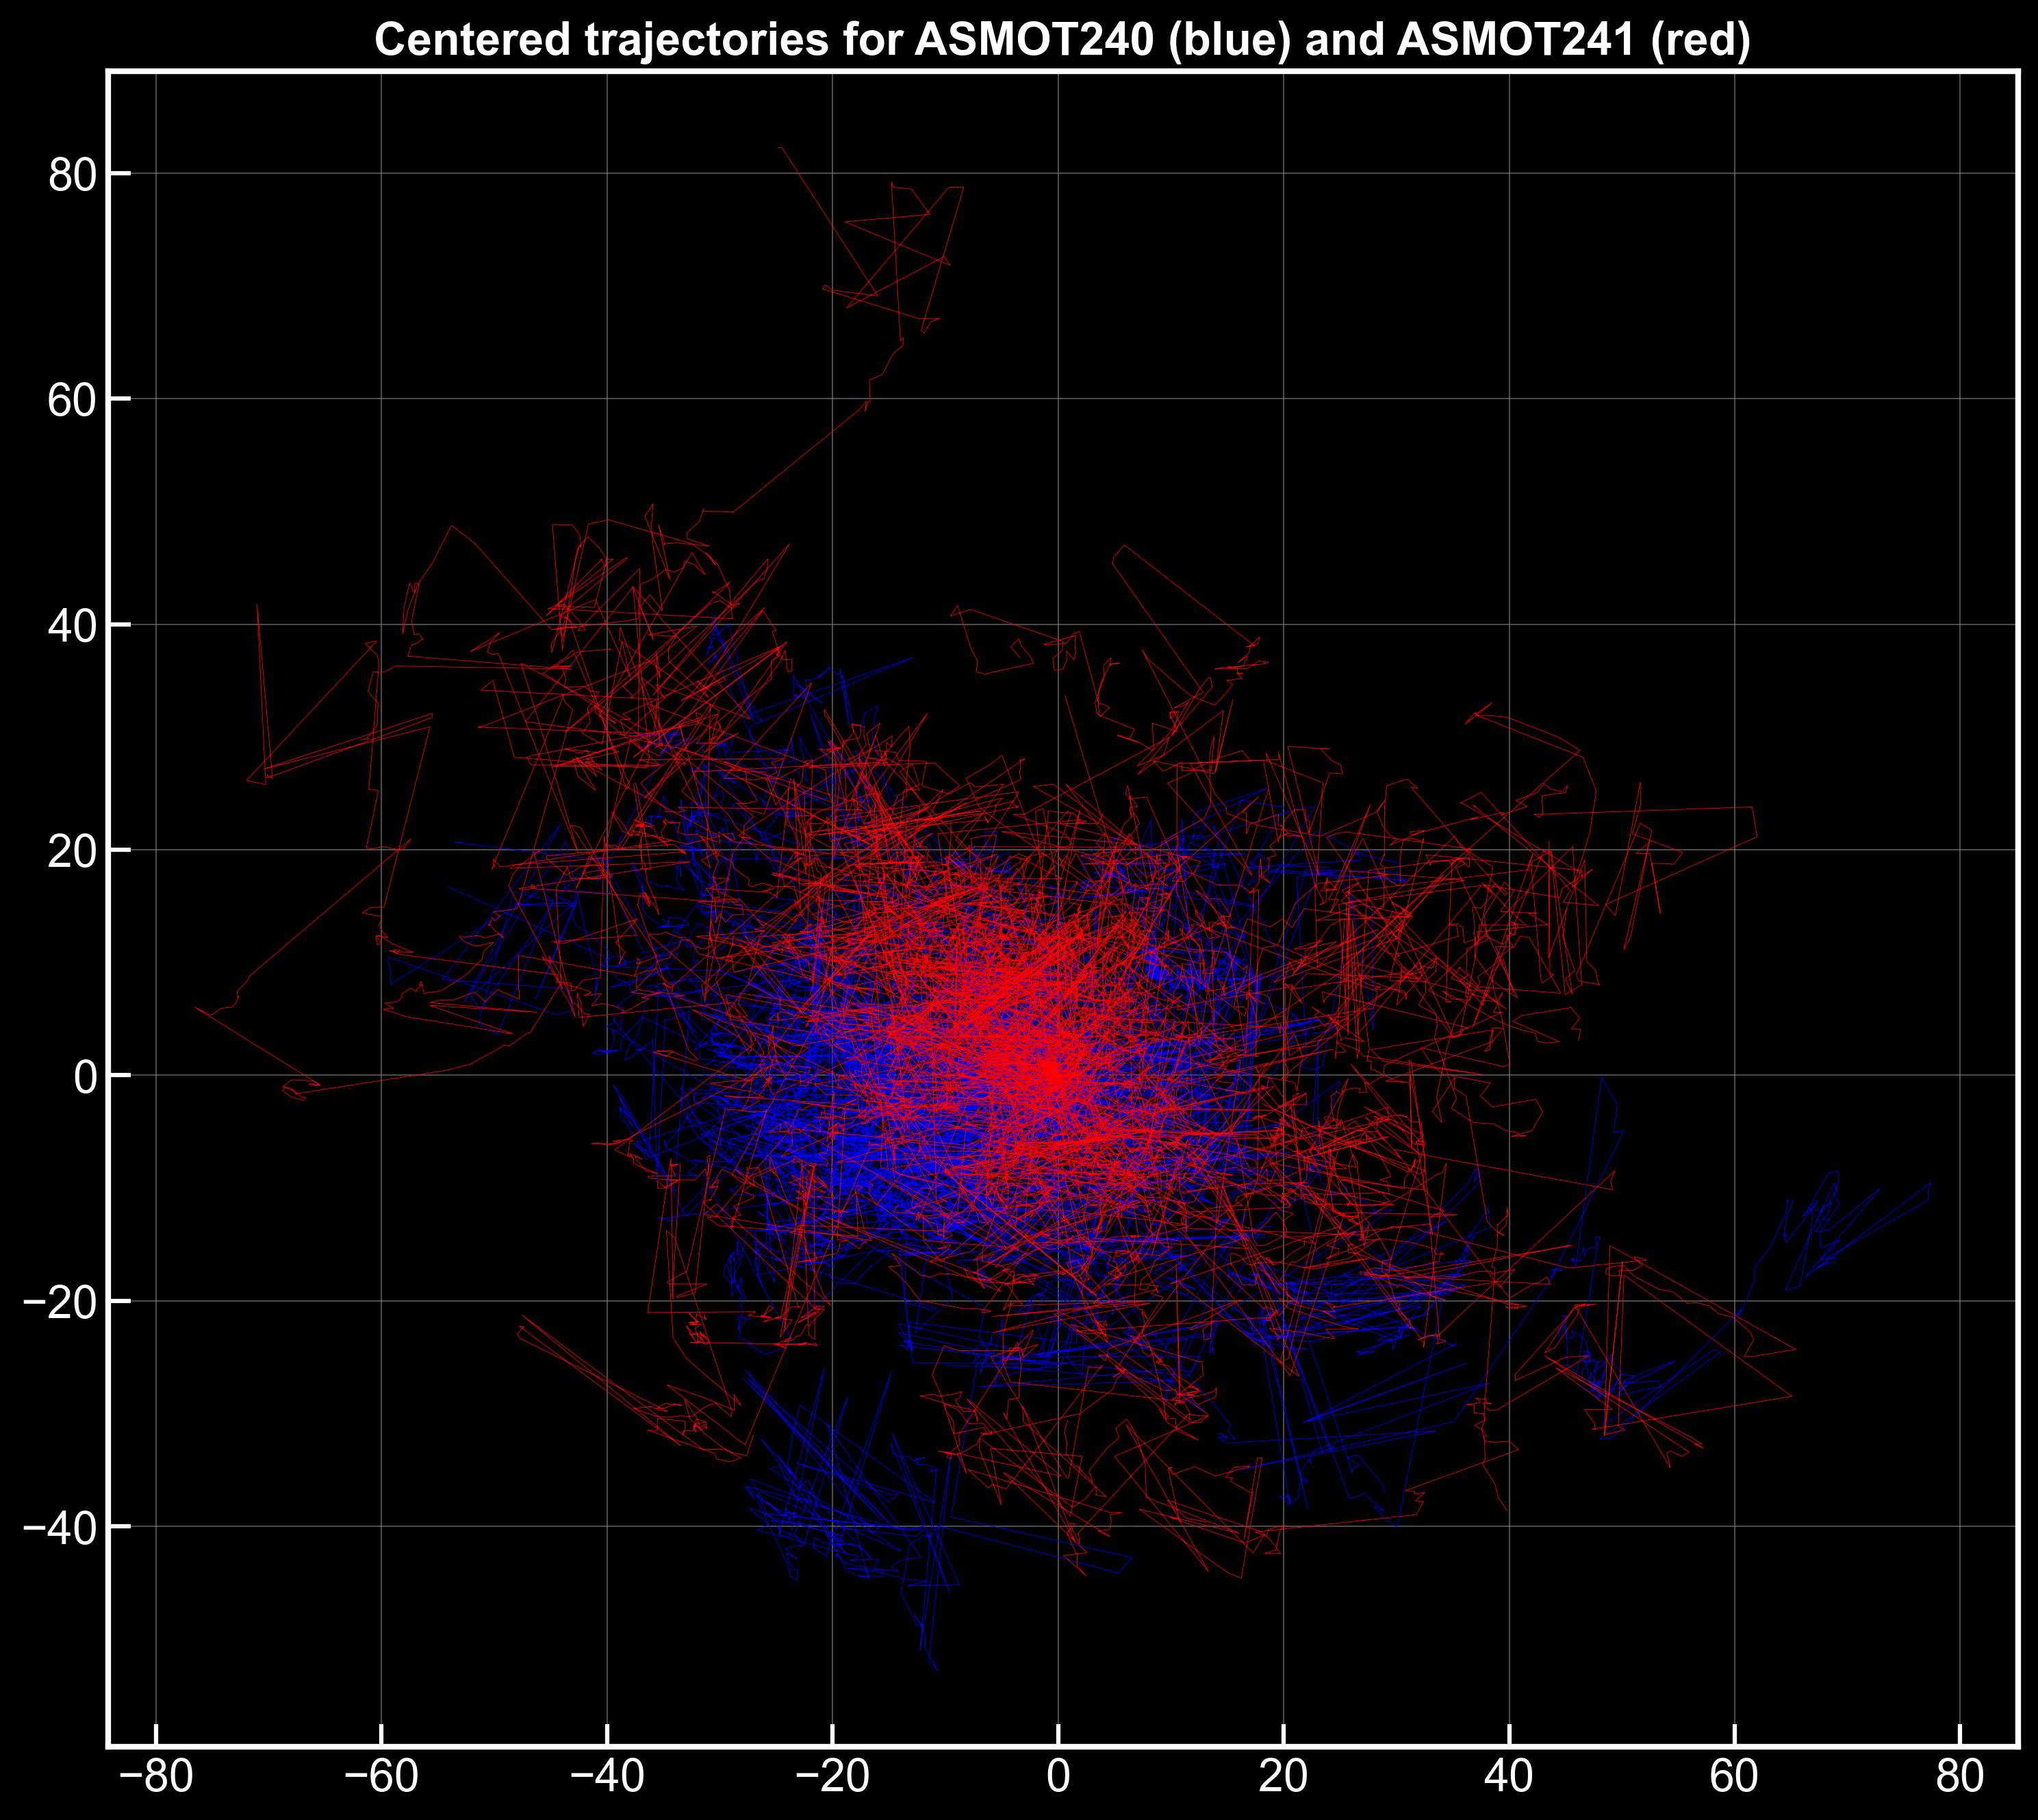

In [159]:
# Filtrer les données pour ASMOT240 et ASMOT241
data_240 = DATA[DATA['experiment'] == 'ASMOT240']
data_241 = DATA[DATA['experiment'] == 'ASMOT241']

# Tracer les trajectoires pour les deux manipulations
fig, axis = plt.subplots(figsize=(12, 12), dpi=300)
axis.set_aspect('equal', 'box')
plt.title('Centered trajectories for ASMOT240 (blue) and ASMOT241 (red)', fontsize=16)

# Tracer manuellement les trajectoires pour ASMOT240 (bleu)
for particle, group in DATA[DATA['experiment'] == 'ASMOT240'].groupby('particle'):
    axis.plot(group['Xc [pix]'], group['Yc [pix]'], color='blue', linewidth=0.2)

# Tracer manuellement les trajectoires pour ASMOT241 (rouge)
for particle, group in DATA[DATA['experiment'] == 'ASMOT241'].groupby('particle'):
    axis.plot(group['Xc [pix]'], group['Yc [pix]'], color='red', linewidth=0.2)

# Sauvegarder et afficher
plt.show()
fig.savefig(os.path.join(path_save_pic, f'Centered_trajectories_ASMOT240_241.{IMG_TYPE}'),
            format=IMG_TYPE, dpi=300, bbox_inches='tight')

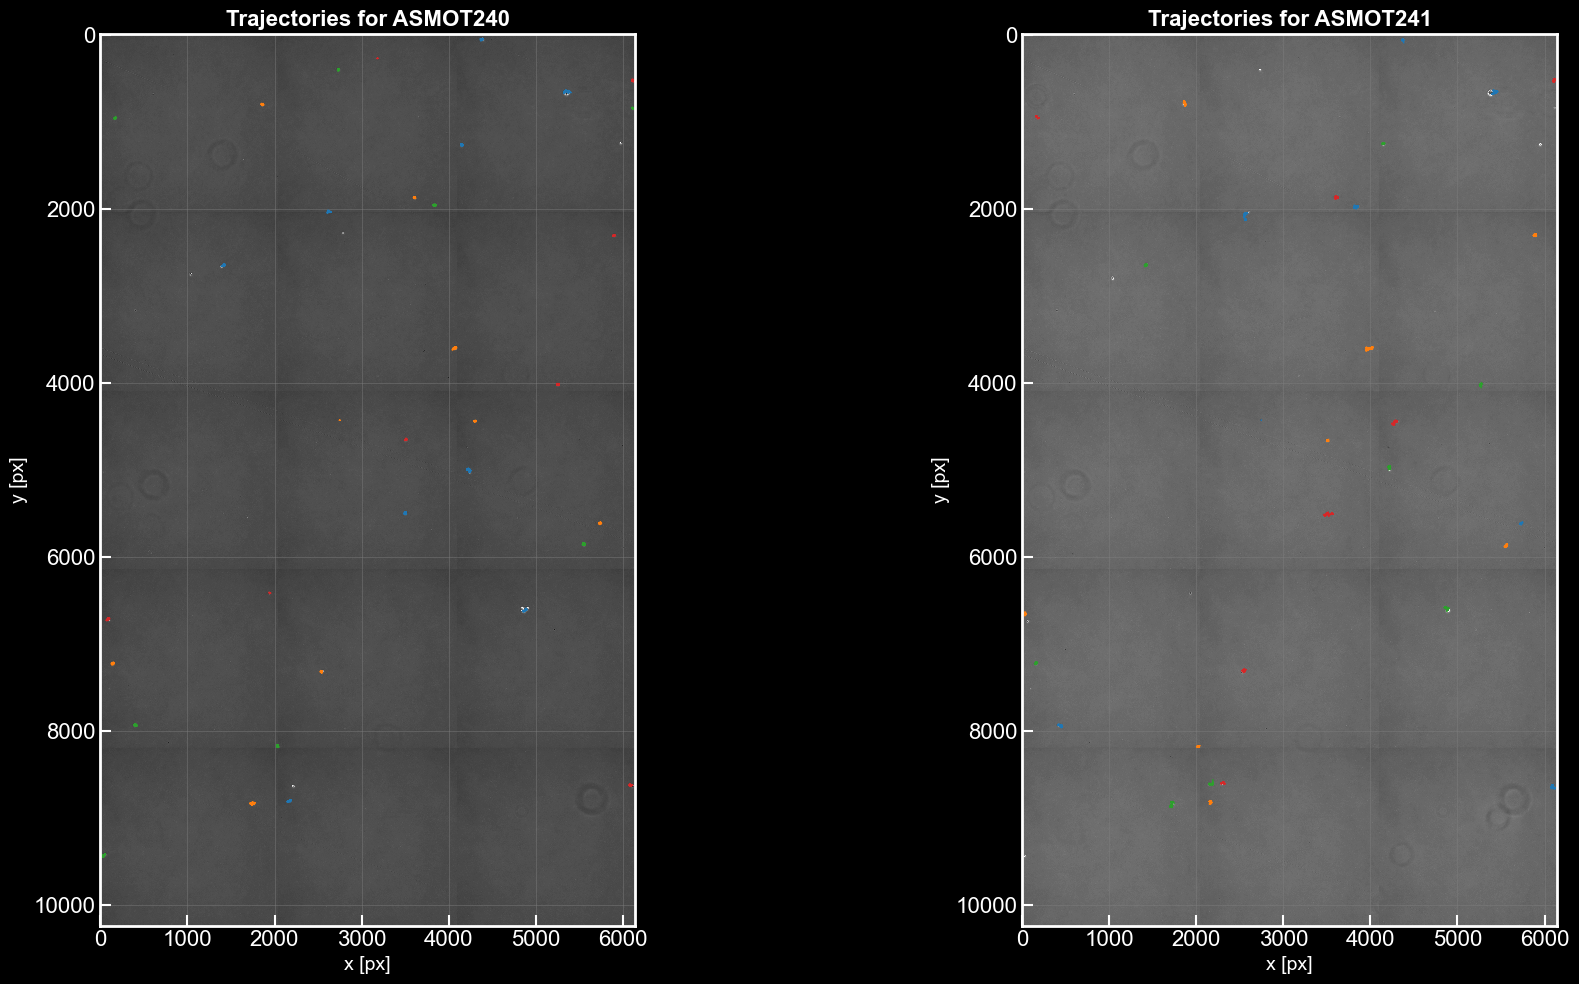

In [118]:
# Plot Trajectories on Original Frames
def plot_trajectories_on_frames(DATA, path_save_pic, GENERAL_PATH_PICTURES, CONDITION_simple):
    image_path = os.path.join(GENERAL_PATH_PICTURES, f"{CONDITION_simple}_faits")
    plot_exp = DATA.groupby('experiment')
    num_experiments = len(plot_exp)
    num_cols = 2
    num_rows = (num_experiments + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 10))
    axes = axes.flatten()
    for ax, (exp_name, exp_data) in zip(axes, plot_exp):
        exp_directories = []
        for dirpath, dirnames, _ in os.walk(image_path):
            for dirname in dirnames:
                if exp_name in dirname:
                    full_path = os.path.join(dirpath, dirname)
                    exp_directories.append(full_path)
        if exp_directories:
            image_path_directory = os.path.join(exp_directories[0], 'mosaic', 'mosaic_total_0.tif')
            frame = imageio.imread(image_path_directory)
            ax.set_aspect('equal', 'box')
            ax.set_title(f'Trajectories for {exp_name}')
            tp.plot_traj(exp_data, superimpose=frame, label=False, ax=ax)
        else:
            print(f"No directory found for {exp_name}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, 'trajectories_on_frame_all_experiment.pdf'), format='pdf')

plot_trajectories_on_frames(DATA, path_save_pic, GENERAL_PATH_PICTURES, CONDITION_simple)

In [240]:
# Plot Mean Instantaneous Speed per Frame
mean_VitInst_per_frame_240 = data_240.groupby('time (min)')['VitInst [um/min]'].median()
mean_VitInst_per_frame_240 = mean_VitInst_per_frame_240.rolling(5).mean().dropna()
mean_VitInst_per_frame_241 = data_241.groupby('time (min)')['VitInst [um/min]'].median()
mean_VitInst_per_frame_241 = mean_VitInst_per_frame_241.rolling(5).mean().dropna()
mean_VitInst_per_frame_240

time (min)
1.25     2.151727
1.50     2.014113
1.75     2.209755
2.00     2.031510
2.25     2.098742
           ...   
83.75    2.089483
84.00    2.058372
84.25    2.112098
84.50    2.138147
84.75    2.132618
Name: VitInst [um/min], Length: 335, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


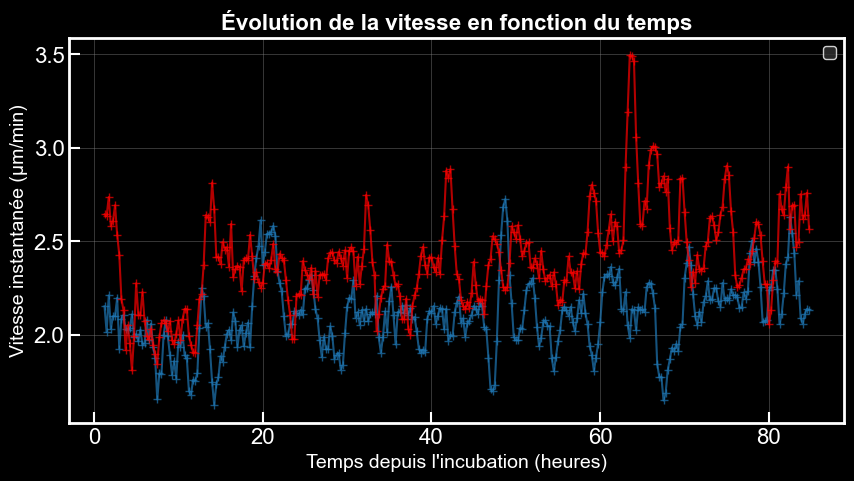

In [140]:
# Tracé du graphique
plt.figure(figsize=(10, 5))
plt.plot(mean_VitInst_per_frame_240.index, mean_VitInst_per_frame_240, marker='+', linestyle='-', alpha=0.7)
plt.plot(mean_VitInst_per_frame_241.index, mean_VitInst_per_frame_241, color = 'red', marker='+', linestyle='-', alpha=0.7)

plt.xlabel("Temps depuis l'incubation (heures)")
plt.ylabel("Vitesse instantanée (µm/min)")
plt.title("Évolution de la vitesse en fonction du temps")
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

###
<center><span style="color: skyblue; font-size: 20px"> Vitesse instantanée moyenne par frame. </span></center>


In [168]:
# Recompute MSD
# DATA_intermediaire = DATA.copy()
data_240['frame'] = pd.factorize(data_240['frame'])[0]
IMSD_240 = tp.imsd(traj=data_240, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')
data_241['frame'] = pd.factorize(data_241['frame'])[0]
IMSD_241 = tp.imsd(traj=data_241, mpp=SIZE_PIX, fps=FPS, max_lagtime=200, statistic='msd')

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_77837/3892515663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_240['frame'] = pd.factorize(data_240['frame'])[0]
/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_77837/3892515663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_241['frame'] = pd.factorize(data_241['frame'])[0]


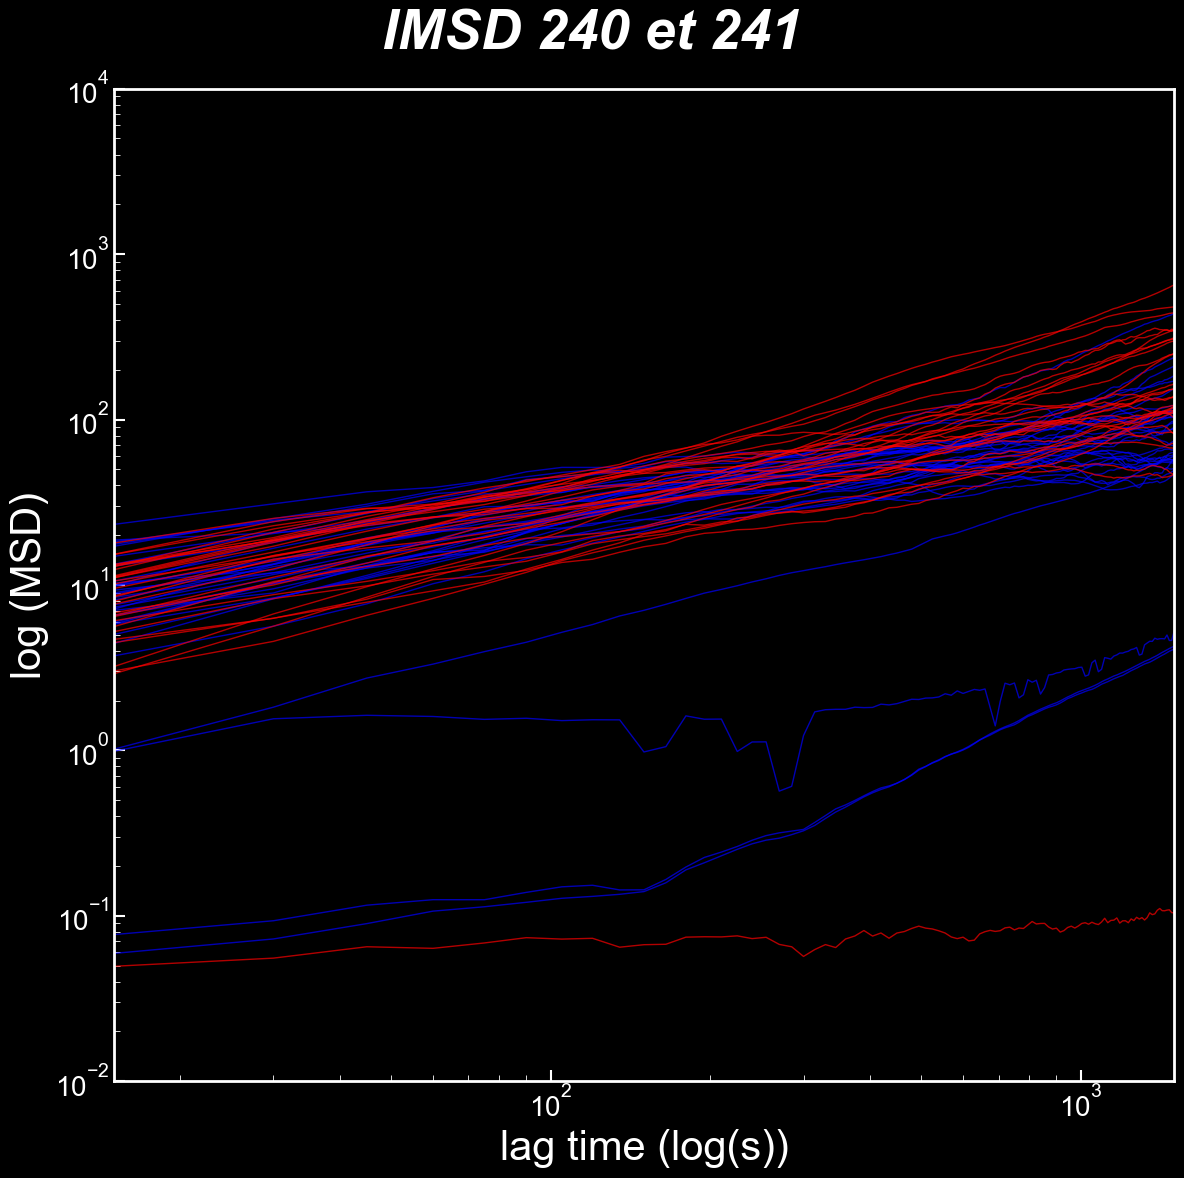

In [164]:
# Create a new figure and axis object
fig, axis = plt.subplots(figsize=(12, 12))

# Plot the MSD data on the axis object
axis.plot(IMSD_240, alpha=0.7, linewidth=1, color='blue')
axis.plot(IMSD_241, alpha=0.7, linewidth=1, color='red')

# Set the limits of the x-axis and y-axis
axis.set_xlim([1 / FPS, 100 / FPS])
axis.set_ylim(0.01, 10000)

# Set the x-axis and y-axis to be on a log scale
axis.set(xscale="log", yscale="log")

# Set the x-axis label
axis.set_xlabel("lag time (log(s))", fontsize=30)

# Set the x-axis label
axis.set_ylabel("log (MSD)", fontsize=30)

# Add a text box to the plot with the number of curves
# textstr = f"n = {nbr_curves}"
props = dict(boxstyle="round", facecolor="dimgrey", alpha=0.5)
# axis.text(0.05, 0.95, textstr, transform=axis.transAxes, fontsize=30,
#             verticalalignment="top", bbox=props)

axis.tick_params(axis='both', which='major', labelsize=20)
axis.grid(which="minor", visible=False)
axis.grid(which="major", visible=False)

# Set the title of the plot
fig.suptitle('IMSD 240 et 241', fontsize=40, fontweight="bold", fontstyle='italic', fontname="Arial")

# Adjust the spacing of the plot
fig.tight_layout()

In [169]:
# Reload custom library
importlib.reload(lib)

<module 'functions_analyze' from '/Users/souchaud/Desktop/Dictyostelium/Motility/Analyse_tracking/tracking_and_analyze/traitement_tracking/functions_analyze.py'>

# negative slope 1


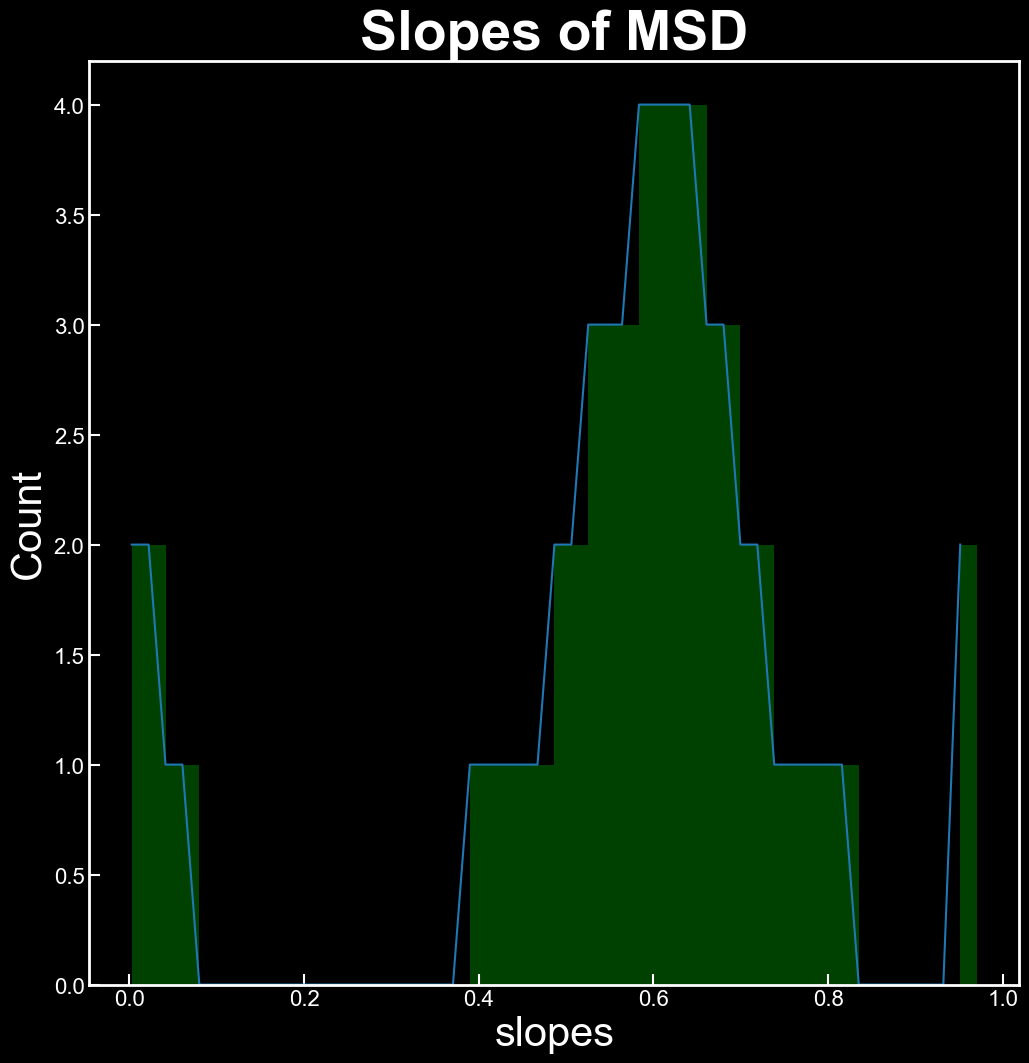

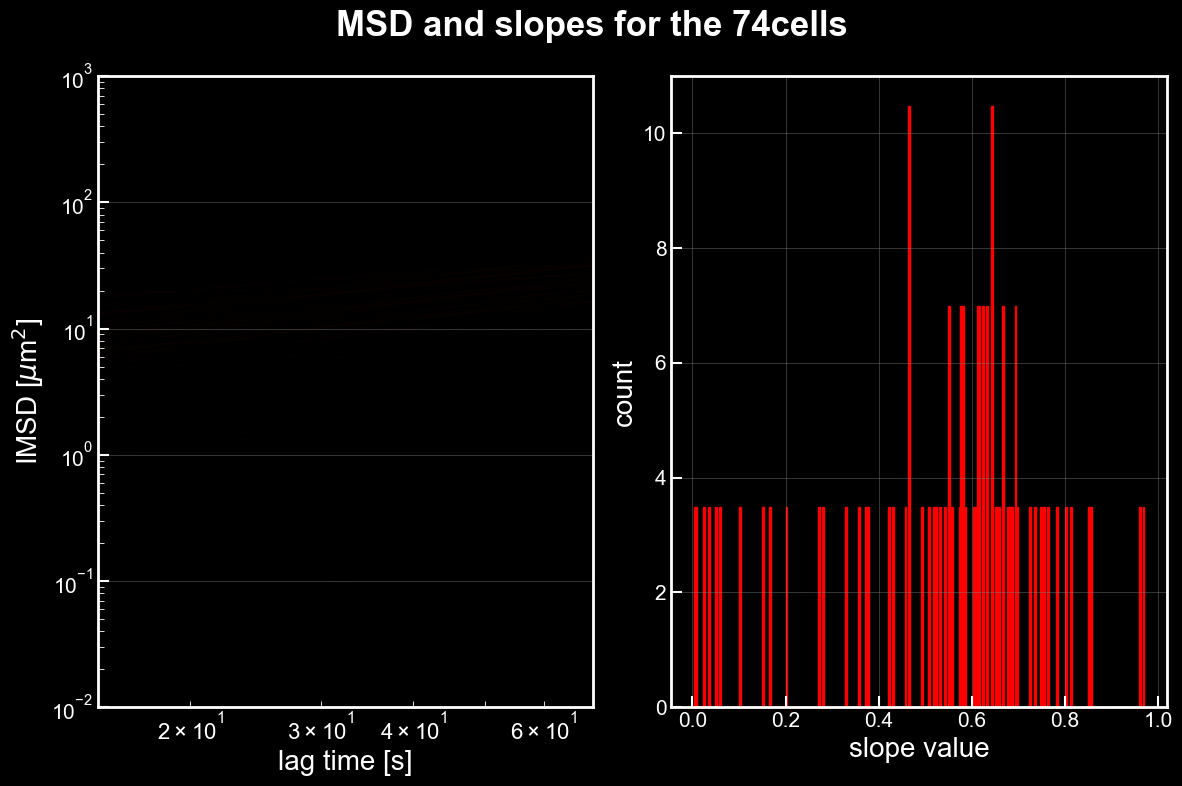

In [195]:
# Recompute trajectory clustering with new cutoff
LAG_TIME_FIT = 5
COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF = lib.traj_clustering_with_fit_cutoff(
    DATA, imsd=IMSD, hist=True, lag_time_fit=LAG_TIME_FIT, micronperpixel=SIZE_PIX,
    fps=FPS, binsize=50, peak_height=50, peak_width=1, save=True, pathway_fig=path_save_pic,
    name='MSD and slopes', img_type=IMG_TYPE, plot=True, color_sup_inf=color_sup_inf,
    cutoff_default=1.25
)

# Ajouter les colonnes 'is_inf' et 'is_sup' à DATA
# data_241['particle'] = data_241['particle'].astype(int)
PART_COEF_INF = set(map(int, PART_COEF_INF))
PART_COEF_SUP = set(map(int, PART_COEF_SUP))

# Ajout des colonnes 'is_inf' et 'is_sup'
DATA['is_inf'] = DATA['particle'].isin(PART_COEF_INF).astype(int)
DATA['is_sup'] = DATA['particle'].isin(PART_COEF_SUP).astype(int)


In [209]:
def get_coefficients_by_experiment(data, coef_inf, coef_sup, part_coef_inf, part_coef_sup, experiment_name):
    """
    Extrait les coefficients correspondant aux particules d'une expérience spécifique.
    """
    # Obtenir les particules de l'expérience
    exp_particles = set(data[data['experiment'] == experiment_name]['particle'].unique())
    
    # Filtrer les particules
    part_coef_inf_exp = part_coef_inf.intersection(exp_particles)
    part_coef_sup_exp = part_coef_sup.intersection(exp_particles)
    
    # Créer les listes de coefficients filtrés
    coef_inf_exp = [coef for i, coef in enumerate(coef_inf) 
                    if list(part_coef_inf)[i] in part_coef_inf_exp]
    coef_sup_exp = [coef for i, coef in enumerate(coef_sup) 
                    if list(part_coef_sup)[i] in part_coef_sup_exp]
    
    return coef_inf_exp, coef_sup_exp, part_coef_inf_exp, part_coef_sup_exp

# Exemple d'utilisation :
COEF_INF_240, COEF_SUP_240, PART_COEF_INF_240, PART_COEF_SUP_240 = get_coefficients_by_experiment(
    DATA, COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, 'ASMOT240'
)

COEF_INF_241, COEF_SUP_241, PART_COEF_INF_241, PART_COEF_SUP_241 = get_coefficients_by_experiment(
    DATA, COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, 'ASMOT241'
)

###
<center><span style="color: skyblue; font-size: 40px">Calculs des différents metrics importants </span></center>


In [ ]:
def calculate_metrics(DATA):
    # Calculer les vitesses moyennes instantanées pour toutes les particules
    mean_vitinst_df = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].mean().reset_index()
    mean_vitinst_df = mean_vitinst_df.rename(columns={'VitInst [um/min]': 'mean_vit_inst'})

    # Calculer les médianes des vitesses instantanées pour toutes les particules
    median_vitinst_df = DATA.groupby(['experiment', 'particle'])['VitInst [um/min]'].median().reset_index()
    median_vitinst_df = median_vitinst_df.rename(columns={'VitInst [um/min]': 'median_vit_inst'})

    # Initialisation d'une liste pour stocker les résultats
    metrics = []

    # Parcours de chaque particule pour calculer les métriques
    for particle, group in DATA.groupby('particle'):
        experiment = group['experiment'].iloc[0]

        # Limiter aux 200 premières lignes
        limited_group = group.head(200)

        # Somme des déplacements (seulement sur les 200 premières lignes)
        displacement_sum = limited_group['displacement [pix]'].sum()

        # Récupérer la vitesse moyenne instantanée pré-calculée
        mean_vit_inst = mean_vitinst_df.loc[
            (mean_vitinst_df['experiment'] == experiment) & (mean_vitinst_df['particle'] == particle),
            'mean_vit_inst'
        ].values[0]

        # Récupérer la médiane des vitesses instantanées pré-calculée
        median_vit_inst = median_vitinst_df.loc[
            (median_vitinst_df['experiment'] == experiment) & (median_vitinst_df['particle'] == particle),
            'median_vit_inst'
        ].values[0]

        # Distance entre la position de départ et d'arrivée
        start_position = limited_group.iloc[0][['x', 'y']].values
        end_position = limited_group.iloc[-1][['x', 'y']].values
        start_end_distance = np.linalg.norm(end_position - start_position)

        # Stocker les résultats dans un dictionnaire
        metrics.append({
            'experiment': experiment,
            'particle': particle,
            'displacement_sum [um]': displacement_sum,
            'mean_vit_inst [um/min]': mean_vit_inst,
            'median_vit_inst [um/min]': median_vit_inst,
            'start_end_distance [um]': start_end_distance
        })

    # Conversion en DataFrame
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Appel de la fonction pour obtenir le DataFrame consolidé
metrics_df_240 = calculate_metrics(data_240)
metrics_df_241 = calculate_metrics(data_241)

all_metrics = pd.concat([metrics_df_240, metrics_df_241], ignore_index=True)

# Affichage pour vérification
all_metrics

experiment  particle  displacement_sum [um]  mean_vit_inst [um/min]  \
0    ASMOT240        37             332.047140                4.672495   
1    ASMOT240        38             756.240693                9.050463   
2    ASMOT240        39             946.849770               10.186321   
3    ASMOT240        40             184.711591                2.202822   
4    ASMOT240        41             749.291069                9.422144   
..        ...       ...                    ...                     ...   
60   ASMOT241        32             400.854357                5.557769   
61   ASMOT241        33             327.319647                3.689319   
62   ASMOT241        34             404.106854                6.095663   
63   ASMOT241        35             504.517928                6.367033   
64   ASMOT241        36             706.897041                7.502411   

    median_vit_inst [um/min]  start_end_distance [um]  
0                   1.759776                25.304819  
1                   2.349448                13.271426  
2                   2.493456                15.235023  
3                   2.068803                12.440413  
4                   2.464329                46.785901  
..                       ...                      ...  
60                  2.681058                 5.083537  
61                  1.832953                22.837831  
62                  2.848752                31.510961  
63                  2.690077                15.228075  
64                  2.708450                44.836468  

[65 rows x 6 columns]

In [210]:
def calculate_all_metrics(DATA):
    """
    Calcule diverses métriques pour chaque expérience, y compris la vitesse moyenne
    des particules sup et inf.
    """
    # Calculer le temps d'incubation et le nombre de particules (exp_hours)
    exp_hours = (
        DATA.groupby('experiment')
        .agg({
            'time to incubation (hours)': 'first',
            'particle': 'nunique'
        })
        .reset_index()
        .rename(columns={'particle': 'number_of_particles'})
    )

    # Compter les particules is_inf et is_sup
    particle_counts = (
        DATA.groupby(['experiment', 'particle'])
        .agg(
            is_inf=('is_inf', 'max'),
            is_sup=('is_sup', 'max')
        )
        .reset_index()
        .groupby('experiment')
        .agg(
            number_of_inf=('is_inf', 'sum'),
            number_of_sup=('is_sup', 'sum')
        )
        .reset_index()
    )
    particle_counts['proportion_inf'] = particle_counts['number_of_inf'] / (
        particle_counts['number_of_inf'] + particle_counts['number_of_sup']
    )

    # Calculer les métriques issues de metrics_df
    metrics_df = DATA.groupby(['experiment', 'particle']).apply(
        lambda group: {
            'displacement_sum [um]': group.head(200)['displacement [pix]'].sum(),
            'start_end_distance [um]': np.linalg.norm(
                group.head(200).iloc[0][['x', 'y']].values -
                group.head(200).iloc[-1][['x', 'y']].values
            ),
            'mean_vit_inst [um/min]': group['VitInst [um/min]'].median()
        }
    ).apply(pd.Series).reset_index()

    # Ajouter la vitesse mediane pour les particules sup et inf
    sup_inf_speeds = DATA.groupby(['experiment', 'particle']).agg(
        is_sup=('is_sup', 'max'),
        is_inf=('is_inf', 'max'),
        mean_vit_inst=('VitInst [um/min]', 'median')
    ).reset_index()

    # Calculer la vitesse mediane des particules sup et inf par expérience
    sup_inf_speeds_agg = sup_inf_speeds.groupby('experiment').agg(
        mean_speed_sup=('mean_vit_inst', lambda x: x[sup_inf_speeds['is_sup'] == 1].median() if (sup_inf_speeds['is_sup'] == 1).any() else 0),
        mean_speed_inf=('mean_vit_inst', lambda x: x[sup_inf_speeds['is_inf'] == 1].median() if (sup_inf_speeds['is_inf'] == 1).any() else 0)
    ).reset_index()

    # Calculer taille et particules par champ
    spatial_metrics = DATA.groupby('experiment').apply(lambda group: {
        'taille': math.ceil(group['y'].max() / 2048) * math.ceil(group['x'].max() / 2048),
        'nombre_part_par_champs': group['particle'].nunique() /
        (math.ceil(group['y'].max() / 2048) * math.ceil(group['x'].max() / 2048)) if (
            math.ceil(group['y'].max() / 2048) * math.ceil(group['x'].max() / 2048)) > 0 else 0
    }).apply(pd.Series).reset_index()

    # Calculer d'autres métriques
    result_metrics = metrics_df.groupby('experiment').agg(
        displacement_sum_mean=('displacement_sum [um]', 'median'),
        start_end_distance_mean=('start_end_distance [um]', 'median'),
        mean_speed=('mean_vit_inst [um/min]', 'median')
    ).reset_index()

    # Fusionner toutes les métriques
    consolidated_metrics = (
        exp_hours
        .merge(particle_counts, on='experiment', how='outer')
        .merge(result_metrics, on='experiment', how='outer')
        .merge(sup_inf_speeds_agg, on='experiment', how='outer')
        .merge(spatial_metrics, on='experiment', how='outer')
    )

    # Renommer les colonnes après la fusion
    consolidated_metrics = consolidated_metrics.rename(columns={
        'displacement_sum_mean': 'displacement_sum_mean [um]',
        'start_end_distance_mean': 'start_end_distance_mean [um]',
        'mean_speed': 'mean_speed [um/min]',
        'mean_speed_sup': 'mean_speed_sup [um/min]',
        'mean_speed_inf': 'mean_speed_inf [um/min]'
    })

    return consolidated_metrics

# Appel de la fonction
all_metrics_df = calculate_all_metrics(DATA)

# Affichage pour vérification
all_metrics_df.head(10)

experiment  time to incubation (hours)  number_of_particles  number_of_inf  \
0   ASMOT240                       75.33                   34             34   
1   ASMOT241                       76.83                   31             31   

   number_of_sup  proportion_inf  displacement_sum_mean [um]  \
0              0             1.0                  417.289515   
1              0             1.0                  469.942577   

   start_end_distance_mean [um]  mean_speed [um/min]  mean_speed_sup [um/min]  \
0                     18.306142             2.338999                        0   
1                     21.148051             2.486998                        0   

   mean_speed_inf [um/min]  taille  nombre_part_par_champs  
0                 2.338999    15.0                2.266667  
1                 2.486998    15.0                2.066667

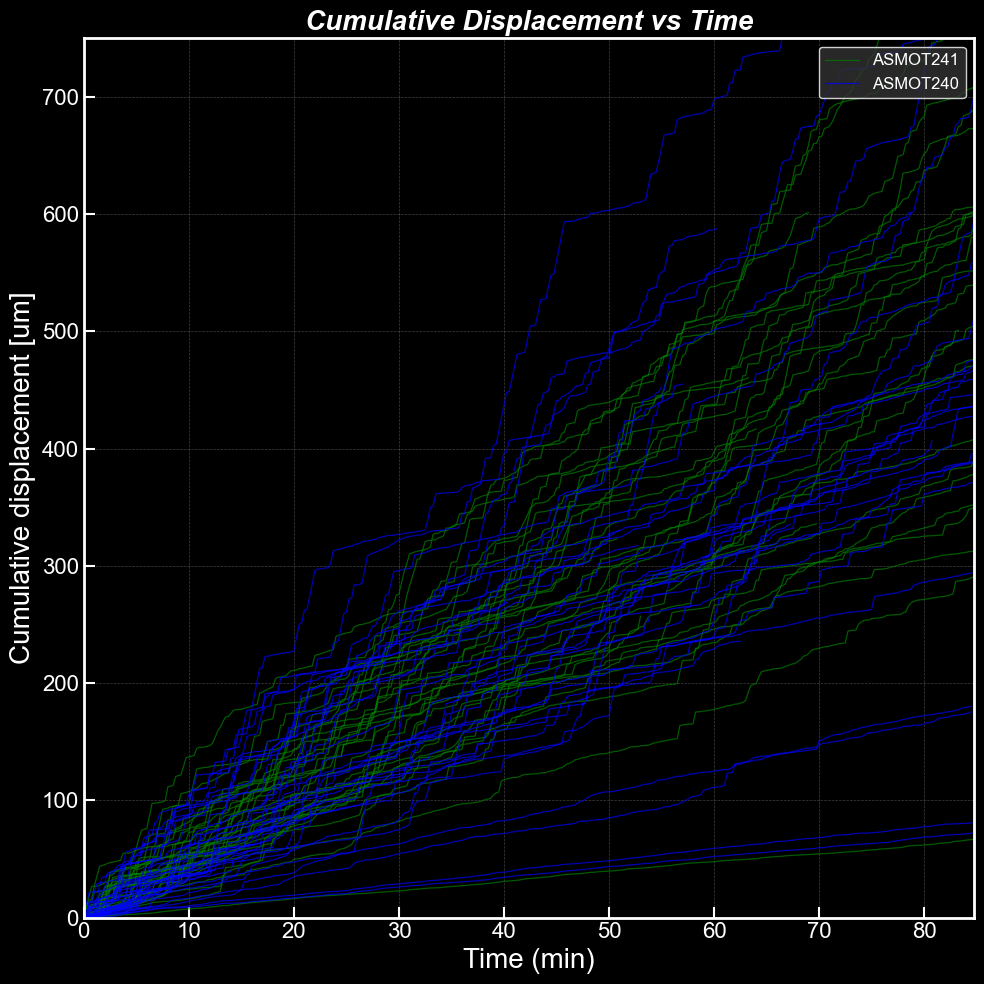

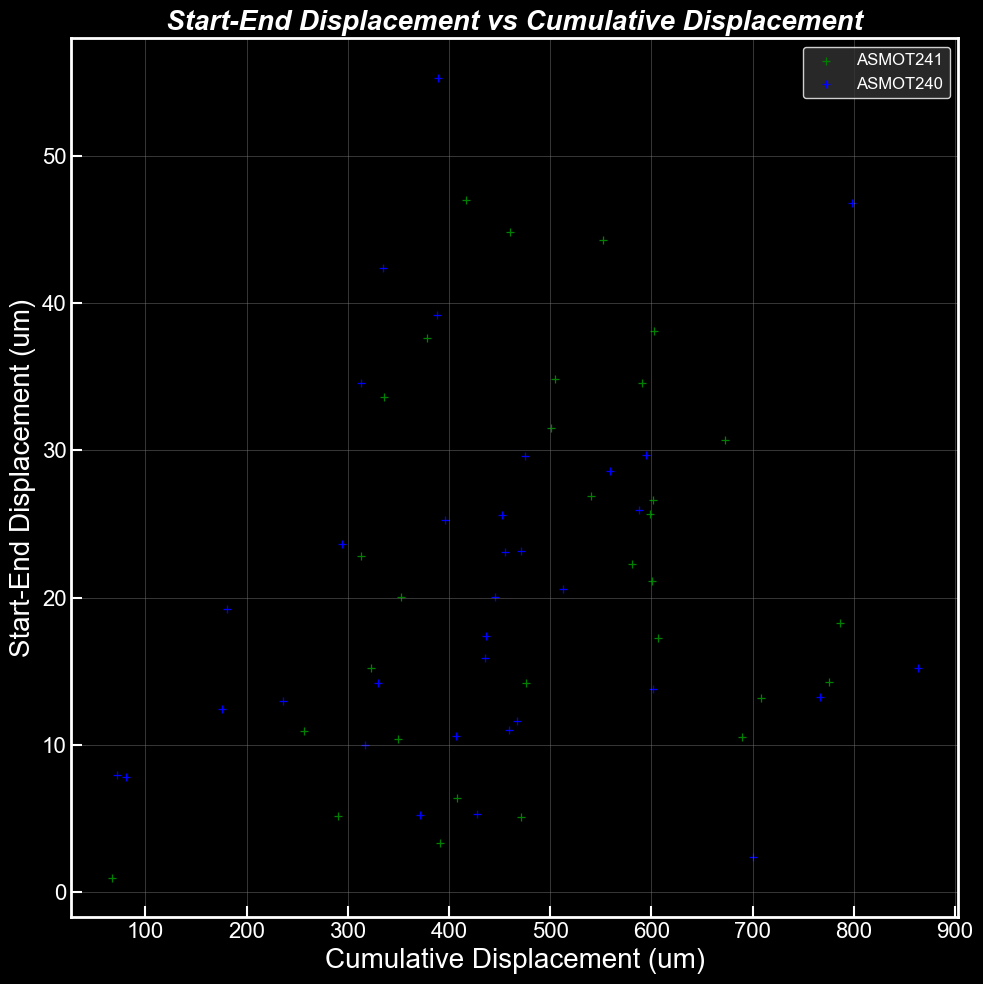

In [190]:
def plot_combined_displacement(traj: pd.DataFrame, start_end: pd.DataFrame,
                               colors: list = ['green', 'blue'], linewidth: float = 0.1,
                               alpha: float = 0.1, save: bool = False, xlim: list = None, ylim: list = None,
                               pathway_saving: str = None, name: str = None, img_type: str = 'jpg'):
    """
    Plot cumulative displacement vs time and start-end vs cumulative displacement for multiple experiments on the same graph.

    Parameters:
    traj : pd.DataFrame - DataFrame containing trajectory data with 'experiment', 'particle', 'time (min)', and 'cumulative displacement [um]'
    start_end : pd.DataFrame - DataFrame containing 'particle' and 'start_end_distance [um]'
    colors : list - List of colors for different experiments
    linewidth : float - Line width for plot lines
    alpha : float - Alpha transparency for lines and markers
    save : bool - Flag to save the generated plot
    xlim : list - X-axis limits for the plot
    ylim : list - Y-axis limits for the plot
    pathway_saving : str - Path to save the plot files
    name : str - Base name for saved plot files
    img_type : str - Image file type for saved plots
    """
    if traj.empty:
        print("Input trajectory dataframe is empty, unable to plot")
        return

    unique_experiments = traj['experiment'].unique()
    fig, ax = plt.subplots(figsize=(10, 10))

    for i, exp in enumerate(unique_experiments):
        data_exp = traj[traj['experiment'] == exp]
        grouped = data_exp.groupby('particle')

        for _, group in grouped:
            adjusted_time = group['time (min)'] - group['time (min)'].iloc[0]
            ax.plot(adjusted_time, group['cumulative displacement [um]'], 
                    alpha=alpha, linewidth=linewidth, color=colors[i % len(colors)], label=exp if _ == list(grouped.groups.keys())[0] else "")

    ax.set_xlabel('Time (min)', fontsize=20)
    ax.set_ylabel('Cumulative displacement [um]', fontsize=20)
    plt.title("Cumulative Displacement vs Time", fontsize=20, fontweight="bold", fontstyle='italic', fontname="Arial")
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if save and pathway_saving and name:
        fig_path = os.path.join(pathway_saving, f"cumulative_displacement_vs_time_combined.{img_type}")
        fig.savefig(fig_path, format=img_type)

    # Add the cumulative displacement to start_end DataFrame
    cumulative = traj.groupby(['experiment', 'particle'])['cumulative displacement [um]'].last().reset_index()

    # Ensure 'start_end' is properly indexed
    if 'experiment' in start_end.columns:
        start_end_combined = start_end.merge(cumulative, on=['experiment', 'particle'], how="inner")
    else:
        start_end_combined = start_end.merge(cumulative, on=['particle'], how="inner")

    # Plot start-end vs cumulative displacement for all experiments
    fig, ax = plt.subplots(figsize=(10, 10))

    for i, exp in enumerate(unique_experiments):
        data_exp = start_end_combined[start_end_combined['experiment'] == exp]
        ax.scatter(data_exp['cumulative displacement [um]'], data_exp['start_end_distance [um]'],
                   marker='+', linewidth=0.9, alpha=1, color=colors[i % len(colors)], label=exp)

    ax.set_xlabel('Cumulative Displacement (um)', fontsize=20)
    ax.set_ylabel('Start-End Displacement (um)', fontsize=20)
    plt.title("Start-End Displacement vs Cumulative Displacement", fontsize=20, 
              fontweight="bold", fontstyle='italic', fontname="Arial")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save and pathway_saving and name:
        fig_path = os.path.join(pathway_saving, f"start_end_vs_cumulative_combined.{img_type}")
        fig.savefig(fig_path, format=img_type)


# Plot Displacement
plot_combined_displacement(
    DATA,
    start_end=all_metrics[['experiment', 'particle', 'start_end_distance [um]']],
    alpha=0.7,
    linewidth=0.9,
    ylim=[0, 750],
    xlim=[0, data_240['time (min)'].max()],
    save=True,
    pathway_saving=path_save_pic,
    name='displacement start-end all',
    img_type=IMG_TYPE
    )


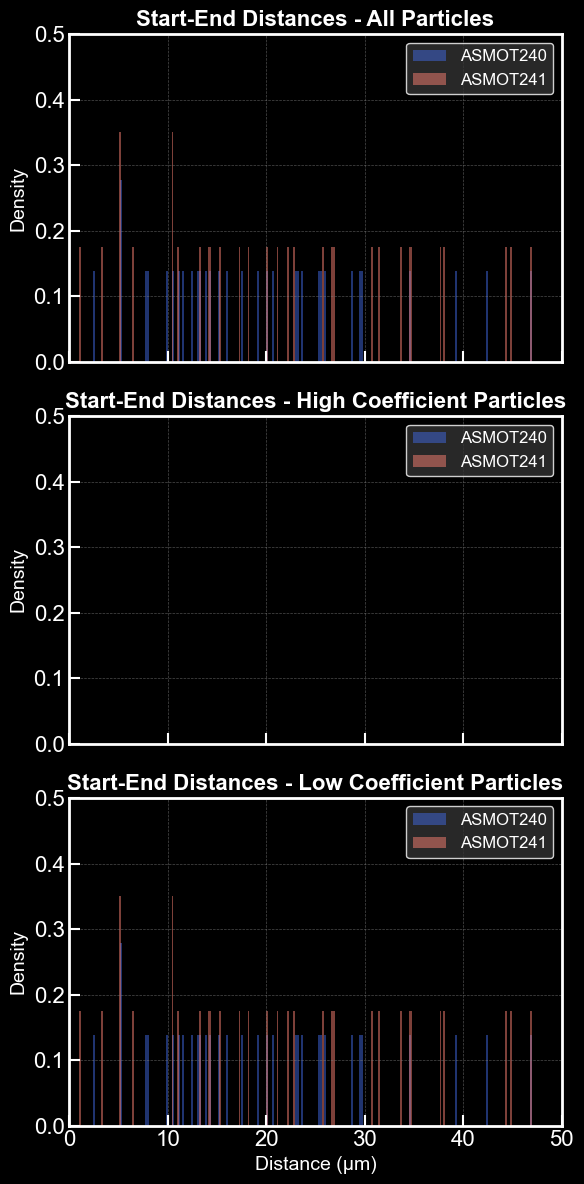

In [188]:
def plot_combined_histograms(all_metrics, PART_COEF_SUP, PART_COEF_INF, IMG_TYPE, path_save_pic):
    """
    Plot histograms of start-end distances for all particles, high coefficient particles, and low coefficient particles.
    Combines data from multiple experiments on the same graphs.

    Parameters:
    - all_metrics : pd.DataFrame - DataFrame containing 'start_end_distance [um]' and 'experiment'
    - PART_COEF_SUP : dict - Dictionary of high coefficient particles per experiment
    - PART_COEF_INF : dict - Dictionary of low coefficient particles per experiment
    - IMG_TYPE : str - Image format for saving plots
    - path_save_pic : str - Path to save the plot
    """
    fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=True, sharey=True)

    colors = {'ASMOT240': 'royalblue', 'ASMOT241': 'salmon'}
    experiments = all_metrics['experiment'].unique()

    # Plot histograms for all particles
    for exp in experiments:
        subset = all_metrics[all_metrics['experiment'] == exp]
        axes[0].hist(subset['start_end_distance [um]'], bins=250, color=colors[exp], alpha=0.5, density=True, label=exp)
    
    axes[0].set_xlim([0, 50])
    axes[0].set_ylim([0, 0.5])
    axes[0].set_title('Start-End Distances - All Particles', fontsize=16)
    axes[0].set_ylabel('Density', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Plot histograms for high coefficient particles
    for exp in experiments:
        subset = all_metrics[(all_metrics['experiment'] == exp) & (all_metrics['particle'].isin(PART_COEF_SUP[exp]))]
        axes[1].hist(subset['start_end_distance [um]'], bins=250, color=colors[exp], alpha=0.5, density=True, label=exp)
    
    axes[1].set_xlim([0, 50])
    axes[1].set_title('Start-End Distances - High Coefficient Particles', fontsize=16)
    axes[1].set_ylabel('Density', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    # Plot histograms for low coefficient particles
    for exp in experiments:
        subset = all_metrics[(all_metrics['experiment'] == exp) & (all_metrics['particle'].isin(PART_COEF_INF[exp]))]
        axes[2].hist(subset['start_end_distance [um]'], bins=250, color=colors[exp], alpha=0.5, density=True, label=exp)
    
    axes[2].set_xlim([0, 50])
    axes[2].set_title('Start-End Distances - Low Coefficient Particles', fontsize=16)
    axes[2].set_xlabel('Distance (μm)', fontsize=14)
    axes[2].set_ylabel('Density', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(path_save_pic, f"Nstart_end_combined.{IMG_TYPE}"), format=IMG_TYPE)
    plt.show()

plot_combined_histograms(
    all_metrics, 
    PART_COEF_SUP={'ASMOT240': PART_COEF_SUP_240, 'ASMOT241': PART_COEF_SUP_241}, 
    PART_COEF_INF={'ASMOT240': PART_COEF_INF_240, 'ASMOT241': PART_COEF_INF_241}, 
    IMG_TYPE=IMG_TYPE, 
    path_save_pic=path_save_pic
)

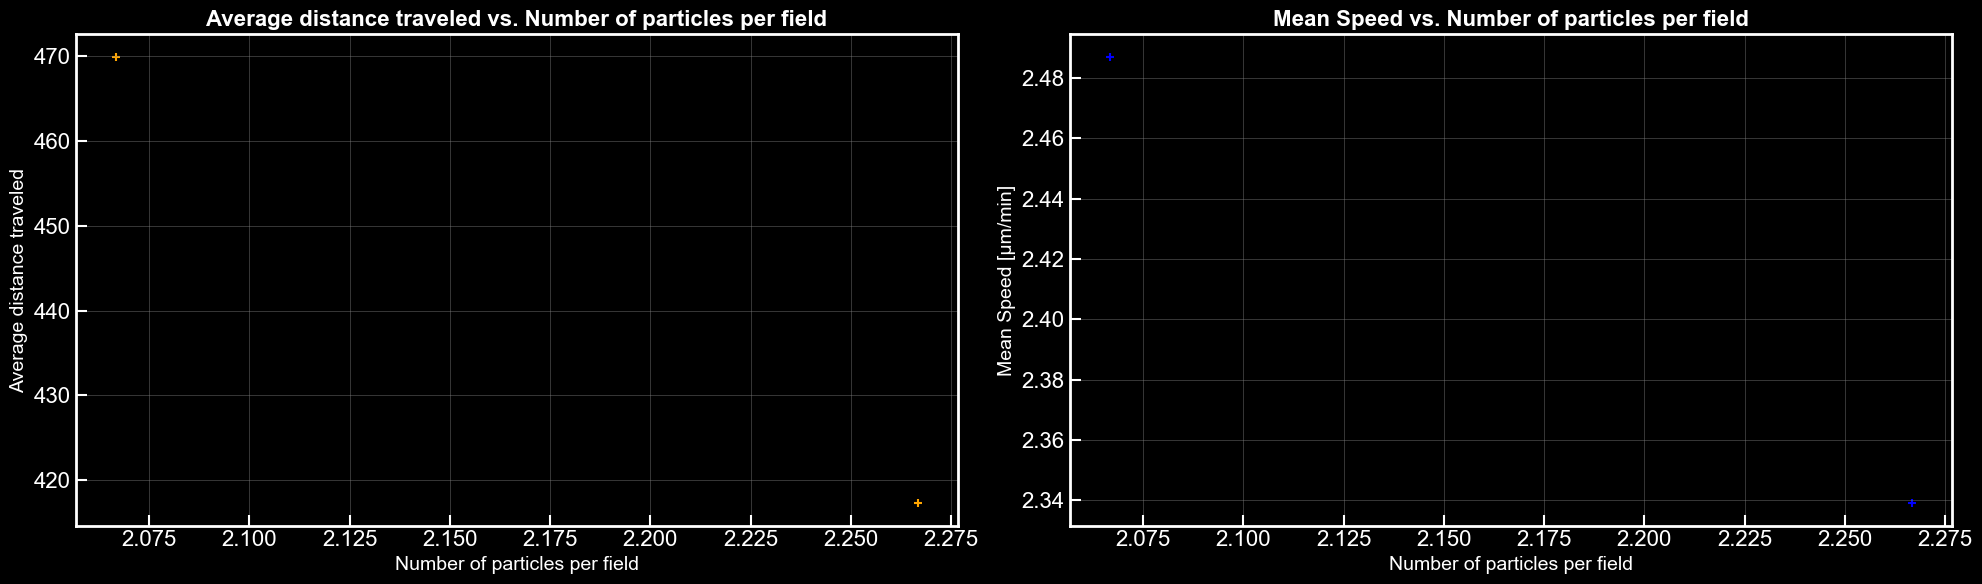

In [211]:
# Plot Results in Function of Number of Particles per Field
def plot_results_vs_particles(all_metrics_df, path_save_pic, CONDITION_simple, img_type='svg'):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    ax1, ax2 = axes.flatten()
    ax1.scatter(all_metrics_df['nombre_part_par_champs'], all_metrics_df['displacement_sum_mean [um]'], marker='+', color='orange')
    ax1.set_title('Average distance traveled vs. Number of particles per field')
    ax1.set_xlabel('Number of particles per field')
    ax1.set_ylabel('Average distance traveled')
    ax2.scatter(all_metrics_df['nombre_part_par_champs'], all_metrics_df['mean_speed [um/min]'], marker='+', color='blue')
    ax2.set_title('Mean Speed vs. Number of particles per field')
    ax2.set_xlabel('Number of particles per field')
    ax2.set_ylabel('Mean Speed [μm/min]')
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(path_save_pic, f"Results_vs_particles_{CONDITION_simple}.{img_type}"), format=img_type)

plot_results_vs_particles(all_metrics_df, path_save_pic, CONDITION_simple, img_type=IMG_TYPE)

In [215]:
# Compute Angle Changes between Directions
def compute_angle_changes(DATA, PART_COEF_SUP, PART_COEF_INF):
    def angle_between_directions(row):
        dx1, dy1 = row['dir_x'], row['dir_y']
        dx2, dy2 = row['dir_x_next'], row['dir_y_next']
        angle_initial = np.arctan2(dy1, dx1)
        angle_final = np.arctan2(dy2, dx2)
        angle_change = angle_final - angle_initial
        angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi
        return np.degrees(angle_change)

    df_sup = DATA[DATA['particle'].isin(PART_COEF_SUP)].copy()
    df_sup.sort_values(by=['particle', 'frame'], inplace=True)
    df_sup['dir_x'] = df_sup.groupby('particle')['x'].diff().fillna(0)
    df_sup['dir_y'] = df_sup.groupby('particle')['y'].diff().fillna(0)
    df_sup['dir_x_next'] = df_sup.groupby('particle')['dir_x'].shift(-1)
    df_sup['dir_y_next'] = df_sup.groupby('particle')['dir_y'].shift(-1)
    df_sup['angle_change'] = df_sup.apply(angle_between_directions, axis=1)
    df_sup.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    df_inf = DATA[DATA['particle'].isin(PART_COEF_INF)].copy()
    df_inf.sort_values(by=['particle', 'frame'], inplace=True)
    df_inf['dir_x'] = df_inf.groupby('particle')['x'].diff().fillna(0)
    df_inf['dir_y'] = df_inf.groupby('particle')['y'].diff().fillna(0)
    df_inf['dir_x_next'] = df_inf.groupby('particle')['dir_x'].shift(-1)
    df_inf['dir_y_next'] = df_inf.groupby('particle')['dir_y'].shift(-1)
    df_inf['angle_change'] = df_inf.apply(angle_between_directions, axis=1)
    df_inf.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

    return df_sup, df_inf

df_sup_240, df_inf_240 = compute_angle_changes(DATA, PART_COEF_SUP_240, PART_COEF_INF_240)
df_sup_241, df_inf_241 = compute_angle_changes(DATA, PART_COEF_SUP_241, PART_COEF_INF_241)

/opt/anaconda3/envs/tracking_and_analyse/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


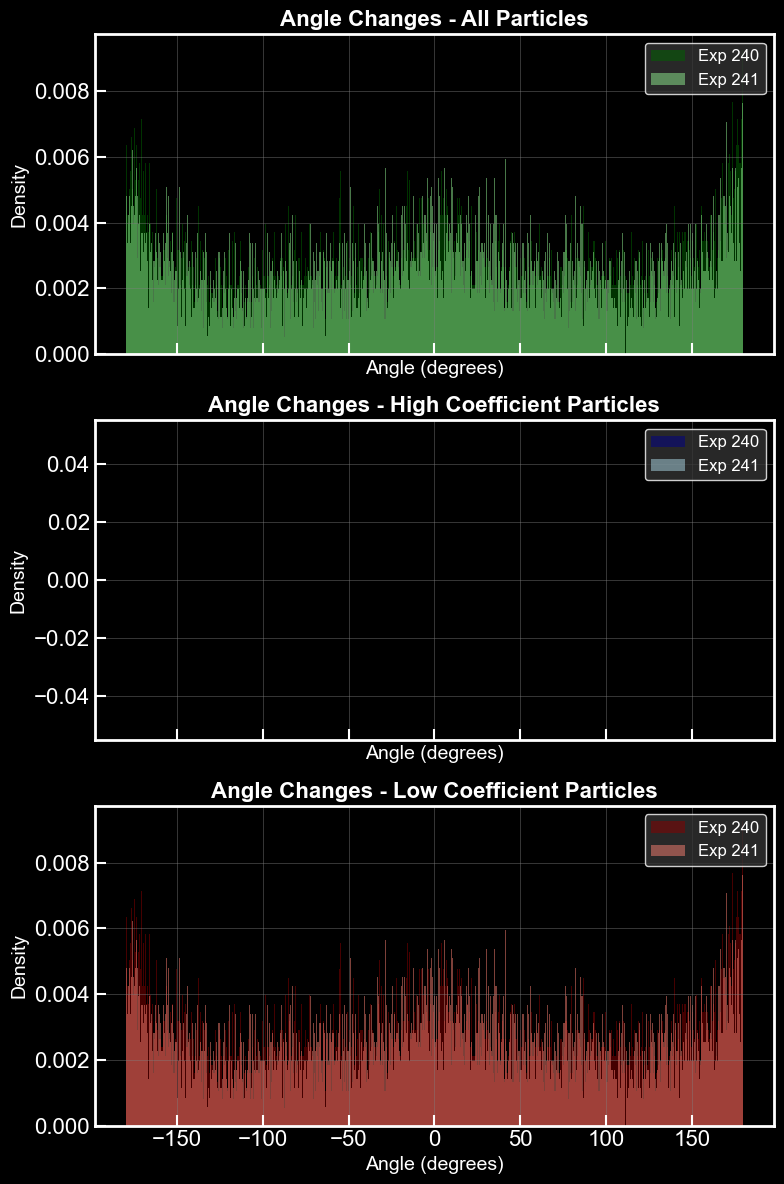

In [222]:
def plot_combined_angle_histograms(df_all_240, df_sup_240, df_inf_240, 
                                 df_all_241, df_sup_241, df_inf_241, 
                                 path_save_pic, img_type='svg'):
    """
    Plot histograms of angle changes for both experiments (240 and 241) on the same graphs.
    
    Parameters:
    -----------
    df_all_240, df_all_241 : pandas.DataFrame
        DataFrames containing all particles for each experiment
    df_sup_240, df_sup_241 : pandas.DataFrame
        DataFrames containing high coefficient particles for each experiment
    df_inf_240, df_inf_241 : pandas.DataFrame
        DataFrames containing low coefficient particles for each experiment
    path_save_pic : str
        Path to save the figure
    img_type : str
        Type of image to save (default: 'svg')
    """
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
    
    # All particles
    axes[0].hist(df_all_240['angle_change'], bins=1000, alpha=0.5, color='darkgreen', 
                 label='Exp 240', density=True)
    axes[0].hist(df_all_241['angle_change'], bins=1000, alpha=0.5, color='lightgreen', 
                 label='Exp 241', density=True)
    axes[0].set_title('Angle Changes - All Particles')
    axes[0].set_xlabel('Angle (degrees)')
    axes[0].set_ylabel('Density')
    axes[0].legend()

    # High coefficient particles
    axes[1].hist(df_sup_240['angle_change'], bins=1000, alpha=0.5, color='darkblue', 
                 label='Exp 240', density=True)
    axes[1].hist(df_sup_241['angle_change'], bins=1000, alpha=0.5, color='lightblue', 
                 label='Exp 241', density=True)
    axes[1].set_title('Angle Changes - High Coefficient Particles')
    axes[1].set_xlabel('Angle (degrees)')
    axes[1].set_ylabel('Density')
    axes[1].legend()

    # Low coefficient particles
    axes[2].hist(df_inf_240['angle_change'], bins=1000, alpha=0.5, color='darkred', 
                 label='Exp 240', density=True)
    axes[2].hist(df_inf_241['angle_change'], bins=1000, alpha=0.5, color='salmon', 
                 label='Exp 241', density=True)
    axes[2].set_title('Angle Changes - Low Coefficient Particles')
    axes[2].set_xlabel('Angle (degrees)')
    axes[2].set_ylabel('Density')
    axes[2].legend()

    plt.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(path_save_pic, f'Combined_Angle_Changes_Histograms.{img_type}'), 
                format=img_type)

def calculate_angle_changes(df):
    """
    Calcule les changements d'angle pour chaque trajectoire.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame contenant les colonnes 'x' et 'y'
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame original avec une nouvelle colonne 'angle_change'
    """
    # Faire une copie du DataFrame
    df = df.copy()
    
    # Calculer les déplacements
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    
    # Calculer les angles en radians
    angles = np.arctan2(df['dy'], df['dx'])
    
    # Calculer les changements d'angle
    df['angle'] = angles
    df['angle_change'] = df.groupby('particle')['angle'].diff()
    
    # Convertir en degrés et normaliser entre -180 et 180
    df['angle_change'] = np.degrees(df['angle_change'])
    df['angle_change'] = ((df['angle_change'] + 180) % 360) - 180
    
    return df

# Préparation des données pour l'expérience 240
df_240 = DATA[DATA['experiment'] == 'ASMOT240'].copy()
df_240 = calculate_angle_changes(df_240)
df_sup_240 = df_240[df_240['is_sup'] == 1].copy()
df_inf_240 = df_240[df_240['is_inf'] == 1].copy()
df_all_240 = df_240.copy()

# Préparation des données pour l'expérience 241
df_241 = DATA[DATA['experiment'] == 'ASMOT241'].copy()
df_241 = calculate_angle_changes(df_241)
df_sup_241 = df_241[df_241['is_sup'] == 1].copy()
df_inf_241 = df_241[df_241['is_inf'] == 1].copy()
df_all_241 = df_241.copy()

# Appel de la fonction de visualisation
plot_combined_angle_histograms(
    df_all_240, df_sup_240, df_inf_240,
    df_all_241, df_sup_241, df_inf_241,
    path_save_pic, img_type=IMG_TYPE
)

# Afficher

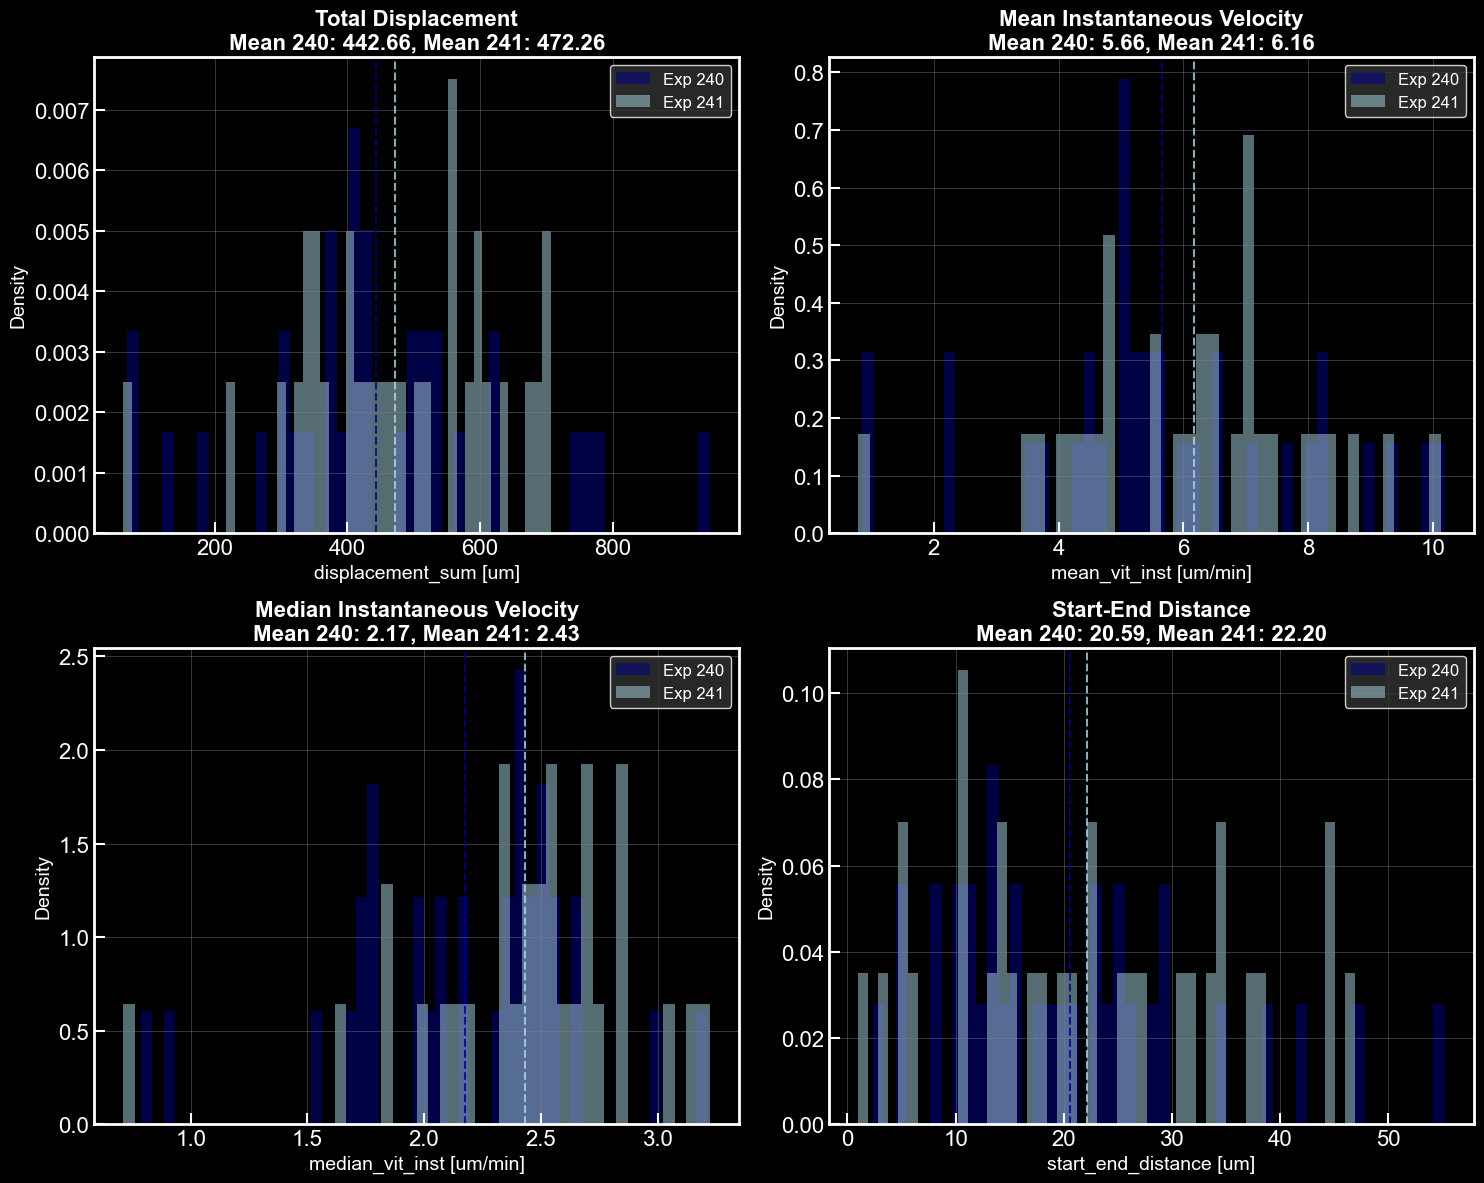


Résumé statistique des métriques:
                     Metric    Mean_240     Std_240    Mean_241     Std_241
0     displacement_sum [um]  442.659676  192.641963  472.260223  151.368628
1    mean_vit_inst [um/min]    5.656007    2.305981    6.161706    1.936707
2  median_vit_inst [um/min]    2.173893    0.507376    2.433193    0.489521
3   start_end_distance [um]   20.589441   12.389867   22.196232   13.038999


In [217]:
def plot_combined_metrics_histograms(metrics_df_240, metrics_df_241, path_save_pic, img_type='svg'):
    """
    Plot histograms of various metrics for both experiments (240 and 241).
    
    Parameters:
    -----------
    metrics_df_240, metrics_df_241 : pandas.DataFrame
        DataFrames containing metrics for each experiment
    path_save_pic : str
        Path to save the figure
    img_type : str
        Type of image to save (default: 'svg')
    """
    metrics_to_plot = [
        ('displacement_sum [um]', 'Total Displacement'),
        ('mean_vit_inst [um/min]', 'Mean Instantaneous Velocity'),
        ('median_vit_inst [um/min]', 'Median Instantaneous Velocity'),
        ('start_end_distance [um]', 'Start-End Distance')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, (metric, title) in enumerate(metrics_to_plot):
        # Exp 240
        axes[idx].hist(metrics_df_240[metric], bins=50, alpha=0.5, color='darkblue',
                      label='Exp 240', density=True)
        # Exp 241
        axes[idx].hist(metrics_df_241[metric], bins=50, alpha=0.5, color='lightblue',
                      label='Exp 241', density=True)
        
        axes[idx].set_title(title)
        axes[idx].set_xlabel(metric)
        axes[idx].set_ylabel('Density')
        axes[idx].legend()
        
        # Ajouter les moyennes comme des lignes verticales
        mean_240 = metrics_df_240[metric].mean()
        mean_241 = metrics_df_241[metric].mean()
        axes[idx].axvline(mean_240, color='darkblue', linestyle='--', alpha=0.8)
        axes[idx].axvline(mean_241, color='lightblue', linestyle='--', alpha=0.8)
        
        # Ajouter les valeurs moyennes dans le titre
        axes[idx].set_title(f'{title}\nMean 240: {mean_240:.2f}, Mean 241: {mean_241:.2f}')

    plt.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(path_save_pic, f'Combined_Metrics_Histograms.{img_type}'), 
                format=img_type)

    # Retourner un résumé statistique
    stats = pd.DataFrame({
        'Metric': [m[0] for m in metrics_to_plot],
        'Mean_240': [metrics_df_240[m[0]].mean() for m in metrics_to_plot],
        'Std_240': [metrics_df_240[m[0]].std() for m in metrics_to_plot],
        'Mean_241': [metrics_df_241[m[0]].mean() for m in metrics_to_plot],
        'Std_241': [metrics_df_241[m[0]].std() for m in metrics_to_plot]
    })
    
    return stats

# Exemple d'utilisation :
stats = plot_combined_metrics_histograms(
    metrics_df_240,
    metrics_df_241,
    path_save_pic,
    img_type=IMG_TYPE
)

# Afficher le résumé statistique
print("\nRésumé statistique des métriques:")
print(stats)

In [237]:
def plot_velocity_histograms(all_metrics_df, metrics_df, path_save_pic, img_type):
    """
    Plot histograms of mean instantaneous velocities for each experiment, sorted by incubation time.

    Parameters:
    - all_metrics_df (DataFrame): Aggregated metrics per experiment.
    - metrics_df (DataFrame): Metrics for each particle and experiment.
    - path_save_pic (str): Path where the plot will be saved.
    - img_type (str): Image format for saving the plot.
    """
    exp_hours = all_metrics_df[['experiment', 'time to incubation (hours)']].sort_values(by='time to incubation (hours)')
    experiments = exp_hours['experiment'].tolist()
    incubation_times = exp_hours['time to incubation (hours)'].tolist()

    global_min = metrics_df['mean_vit_inst [um/min]'].min()
    global_max = metrics_df['mean_vit_inst [um/min]'].max()
    delta = (global_max - global_min) * 0.1
    global_min -= delta
    global_max += delta

    n_experiments = len(experiments)
    fig, axes = plt.subplots(nrows=n_experiments, ncols=1, figsize=(10, 3 * n_experiments), sharex=True, sharey=True)
    if n_experiments == 1:
        axes = [axes]
    palette = colormaps['tab20']
    colors = [palette(i / n_experiments) for i in range(n_experiments)]

    for idx, ax in enumerate(axes):
        exp = experiments[idx]
        hour = incubation_times[idx]
        data_exp = metrics_df[metrics_df['experiment'] == exp]
        ax.hist(data_exp['mean_vit_inst [um/min]'], bins=30, alpha=0.3, range=(global_min, global_max), color=colors[idx])
        ax.set_title(f'Vit. Inst. Moyenne [μm/min] - {exp} (Incubation: {hour}h)')
        ax.set_xlabel('VitInst [μm/min]')
        ax.set_ylabel('Nombre de particules')

        median_value = all_metrics_df.loc[all_metrics_df['experiment'] == exp, 'mean_speed [um/min]'].values[0]
        ax.axvline(median_value, color='red', linestyle='dashed', linewidth=1)
        ax.text(
            median_value + 0.05 * (global_max - global_min), 
            ax.get_ylim()[1] * 0.95,
            f'Médiane: {median_value:.2f}',
            color='red',
            ha='left'
        )
        ax.set_xlim(global_min, global_max)

    plt.tight_layout()
    fig_path = os.path.join(path_save_pic, f'Velocity_Histograms.{img_type}')
    fig.savefig(fig_path, format=img_type)
    plt.show()
    print(f"Plot saved to {fig_path}")

In [243]:
DATA.columns

Index(['index', 'y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep',
       'frame', 'old_particle', 'count_x', 'experiment', 'condition',
       'count_y', 'particle', 'position', 'time (min)', 'dx [pix]', 'dy [pix]',
       'displacement [pix]', 'VitInst [um/min]', 'time to incubation (hours)',
       'total_path_first_n', 'Xc [pix]', 'Yc [pix]',
       'cumulative displacement [um]', 'is_inf', 'is_sup'],
      dtype='object')

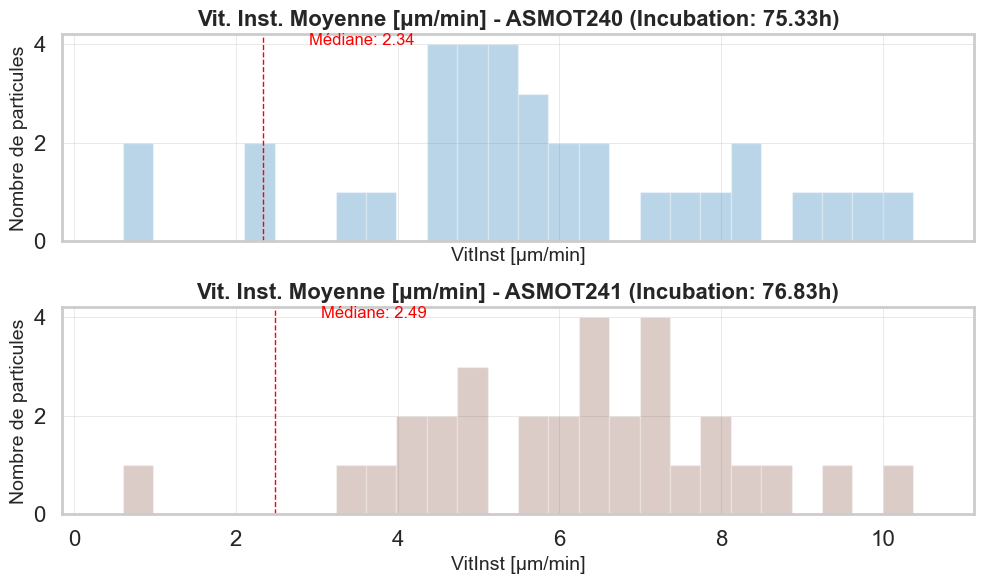

Plot saved to /Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_AMPC_10x_results_tracking_All/Velocity_Histograms.png


In [244]:
# plot_velocity_histograms(all_mean_vitinst, medians, exp_hours, path_save_pic, IMG_TYPE)
plot_velocity_histograms(all_metrics_df, all_metrics, path_save_pic, IMG_TYPE)

<center>Mean speed vs time to incubation </center>

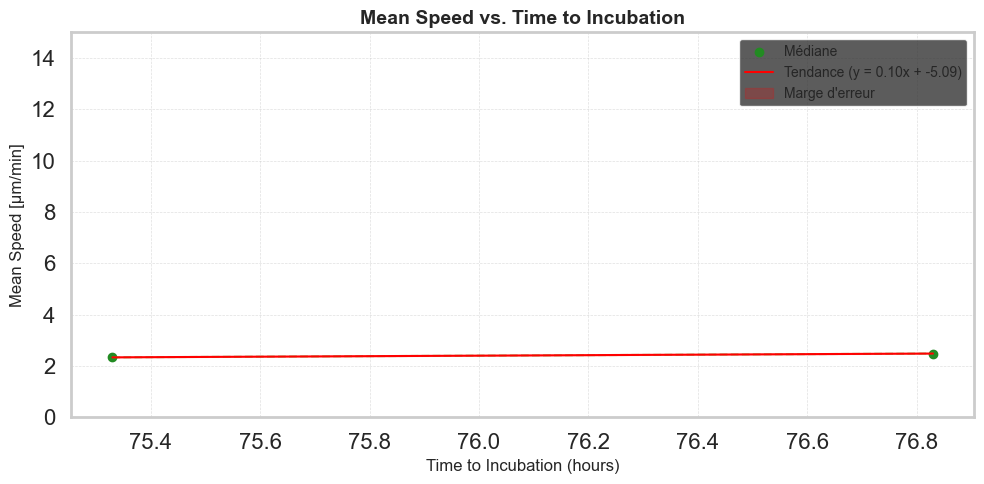

Plot saved to /Users/souchaud/Desktop/Analyses/résultats_CytoOne_HL5_AMPC_10x_results_tracking_All/Mean_Speed_vs_Time_with_Trendline_and_ErrorBand.png


In [246]:
def plot_median_velocity_vs_time(all_metrics_df, path_save_pic, xlim: list = None):
    """
    Plot median velocities as a function of incubation time using all_metrics_df.
    Adds a trendline with a transparent error band to the data.

    Parameters:
    - all_metrics_df (DataFrame): DataFrame containing aggregated metrics for each experiment.
    - path_save_pic (str): Path where the plot will be saved.
    - xlim (list, optional): Limit for the x-axis.
    """
    # Trier les données par temps d'incubation
    all_metrics_sorted = all_metrics_df.sort_values(by='time to incubation (hours)')

    # Extraire les données
    x = all_metrics_sorted['time to incubation (hours)'].values
    y = all_metrics_sorted['mean_speed [um/min]'].values

    # Préparer le tracé
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, color='forestgreen', label='Médiane')  # Points
    plt.plot(x, y, linestyle='--', color='limegreen', alpha=0.6)  # Ligne connectant les points

    # Régression linéaire (y = ax + b)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    trendline = slope * x + intercept

    # Calcul de la zone d'erreur
    error_band = 100*std_err * np.sqrt(1 / len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    # Ajouter la ligne de tendance
    plt.plot(x, trendline, color='red', label=f"Tendance (y = {slope:.2f}x + {intercept:.2f})", linestyle='-', linewidth=1.5)

    # Ajouter l'aire d'erreur
    plt.fill_between(x, trendline - error_band, trendline + error_band, color='red', alpha=0.2, label="Marge d'erreur")

    # Ajouter des labels et des titres
    plt.title('Mean Speed vs. Time to Incubation', fontsize=14)
    plt.xlabel('Time to Incubation (hours)', fontsize=12)
    plt.ylabel('Mean Speed [μm/min]', fontsize=12)
    plt.ylim([0, 15])
    if xlim:
        plt.xlim(xlim)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Sauvegarder et afficher
    plt.tight_layout()
    fig_path = os.path.join(path_save_pic, 'Mean_Speed_vs_Time_with_Trendline_and_ErrorBand.png')
    plt.savefig(fig_path, format='png')
    plt.show()

    print(f"Plot saved to {fig_path}")

#utilisation
plot_median_velocity_vs_time(all_metrics_df, path_save_pic)

In [ ]:
def plot_median_velocity_vs_time(all_metrics_df, path_save_pic, xlim: list = None):
    """
    Plot median velocities as a function of incubation time using all_metrics_df.

    Parameters:
    - all_metrics_df (DataFrame): DataFrame containing aggregated metrics for each experiment.
    - path_save_pic (str): Path where the plot will be saved.
    """
    # Trier les données par temps d'incubation
    all_metrics_sorted = all_metrics_df.sort_values(by='time to incubation (hours)')

    # Préparer le tracé
    plt.figure(figsize=(10, 5))
    plt.scatter(all_metrics_sorted['time to incubation (hours)'], 
                all_metrics_sorted['mean_speed [um/min]'],  # Correction de la colonne utilisée
                color='forestgreen', label='Médiane')
    plt.plot(all_metrics_sorted['time to incubation (hours)'], 
             all_metrics_sorted['mean_speed [um/min]'],  # Correction de la colonne utilisée
             linestyle='--', color='limegreen', alpha=0.6)

    # Ajouter des labels et des titres
    plt.title('Mean Speed vs. Time to Incubation', fontsize=14)
    plt.xlabel('Time to Incubation (hours)', fontsize=12)
    plt.ylim([0, 15])
    plt.ylabel('Mean Speed [μm/min]', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Sauvegarder et afficher
    plt.tight_layout()
    fig_path = os.path.join(path_save_pic, 'Mean_Speed_vs_Time.png')
    plt.savefig(fig_path, format='png')
    plt.show()

    print(f"Plot saved to {fig_path}")

# Appel de la fonction corrigée
plot_median_velocity_vs_time(all_metrics_df, path_save_pic)

In [ ]:
def plot_proportion_vs_time(all_metrics_df, path_save_pic, img_type):
    """
    Plot the proportion of low coefficient particles (proportion_inf) vs. time to incubation.

    Parameters:
    - all_metrics_df (DataFrame): DataFrame containing aggregated metrics for each experiment.
    - path_save_pic (str): Path where the plot will be saved.
    - img_type (str): Image format for saving the plot.
    """
    # Trier les données par temps d'incubation
    all_metrics_sorted = all_metrics_df.sort_values(by='time to incubation (hours)')

    # Préparer le tracé
    plt.figure(figsize=(10, 5))
    plt.scatter(all_metrics_sorted['time to incubation (hours)'], 
                all_metrics_sorted['proportion_inf'], 
                color='red', marker='+', label='Proportion inf')
    
    # Ajouter des titres et des labels
    plt.title('Proportion of Low Coefficient Particles vs. Time to Incubation', fontsize=14)
    plt.xlabel('Time to Incubation (hours)', fontsize=12)
    plt.ylabel('Proportion of Low Coefficient Particles', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Ajuster et sauvegarder
    plt.tight_layout()
    fig_path = os.path.join(path_save_pic, f'Proportion_Low_Coeff_Particles_vs_Time.{img_type}')
    plt.savefig(fig_path, format=img_type)
    plt.show()

    print(f"Plot saved to {fig_path}")

# Appel de la fonction
plot_proportion_vs_time(all_metrics_df, path_save_pic, IMG_TYPE)

In [ ]:
def plot_proportion_per_time_bins(all_metrics_df, path_save_pic, img_type):
    """
    Plot proportions of particles (Inf and Sup) per incubation time bins.

    Parameters:
    - all_metrics_df (DataFrame): DataFrame containing aggregated metrics for each experiment.
    - path_save_pic (str): Path where the plot will be saved.
    - img_type (str): Image format for saving the plot.
    """
    # Définir les intervalles de temps d'incubation
    bins = np.arange(0, all_metrics_df['time to incubation (hours)'].max() + 10, 10)
    labels = [f"{int(left)}-{int(right)}" for left, right in zip(bins[:-1], bins[1:])]
    all_metrics_df['time_bin'] = pd.cut(all_metrics_df['time to incubation (hours)'], bins=bins, labels=labels, right=False)

    # Calculer les proportions moyennes pour chaque bin
    proportion_per_bin_inf = all_metrics_df.groupby('time_bin')['proportion_inf'].mean()
    proportion_per_bin_sup = 1 - proportion_per_bin_inf

    # Configuration des barres pour le tracé
    x = np.arange(len(proportion_per_bin_inf))
    width = 0.35

    # Tracé des proportions
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, proportion_per_bin_inf, width, color='red', alpha=0.7, label='Proportion Inf')
    ax.bar(x + width/2, proportion_per_bin_sup, width, color='blue', alpha=0.7, label='Proportion Sup')
    ax.set_title('Proportion of Particles per Incubation Time Bin', fontsize=14)
    ax.set_xlabel('Incubation Time Bin (hours)', fontsize=12)
    ax.set_ylabel('Average Proportion of Particles', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Sauvegarder et afficher le graphique
    plt.tight_layout()
    fig_path = os.path.join(path_save_pic, f'Proportion_vs_Time_Bins.{img_type}')
    plt.savefig(fig_path, format=img_type)
    plt.show()

    print(f"Plot saved to {fig_path}")

# Appel de la fonction
plot_proportion_per_time_bins(all_metrics_df, path_save_pic, IMG_TYPE)

In [ ]:
# Plot displacement comparison between low and high coefficient particles
lib.plot_displacement_low_and_high(
    traj_sup=df_sup,
    traj_inf=df_inf,
    part_coef_inf=PART_COEF_INF,
    part_coef_sup=PART_COEF_SUP,
    start_end=start_end,
    save=True,
    pathway_saving=path_save_pic,
    name="displacement_start-end_time",
    img_type=IMG_TYPE
)

In [ ]:
def max_displacement_from_start(traj, size_pix):
    """
    Calcule la distance maximale entre le point de départ et toutes les positions
    atteintes par chaque particule.

    Parameters
    ----------
    traj : pandas.DataFrame
        Trajectoire des particules avec colonnes 'x', 'y', 'particle'.
    size_pix : float
        Taille d'un pixel en micromètres.

    Returns
    -------
    max_displacements : pandas.Series
        Distance maximale pour chaque particule.
    """
    # Identifier les coordonnées de départ pour chaque particule
    start_positions = traj.groupby('particle')[['x', 'y']].first()

    # Ajouter les coordonnées de départ au DataFrame
    traj = traj.join(start_positions, on='particle', rsuffix='_start')

    # Calculer les distances à partir du point de départ
    traj['distance_from_start [um]'] = size_pix * np.sqrt(
        (traj['x'] - traj['x_start'])**2 + 
        (traj['y'] - traj['y_start'])**2
    )

    # Trouver la distance maximale pour chaque particule
    max_displacements = traj.groupby('particle')['distance_from_start [um]'].max()

    return max_displacements

# Calcul des distances maximales
max_distances = max_displacement_from_start(DATA, size_pix=SIZE_PIX)

# Filtrage des particules appartenant à PART_COEF_INF et PART_COEF_SUP
distances_part_coef_inf = max_distances[max_distances.index.isin(PART_COEF_INF)]
distances_part_coef_sup = max_distances[max_distances.index.isin(PART_COEF_SUP)]

# Tracer les deux histogrammes sur le même graphique
plt.figure(figsize=(12, 7))
plt.hist(distances_part_coef_inf, bins=100, color='red', alpha=0.5, label='PART_COEF_INF')
plt.hist(distances_part_coef_sup, bins=100, color='blue', alpha=0.5, label='PART_COEF_SUP')
plt.title('Histogramme des distances maximales par catégorie', fontsize=16)
plt.xlabel('Distance maximale [μm]', fontsize=14)
plt.ylabel('Nombre de particules', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
def plot_size_histograms(DATA, PART_COEF_SUP, save=False, pathway_saving=None, img_type="png"):
    """
    Trace un histogramme des tailles des particules par expérience sur une seule figure,
    avec un subplot par expérience.

    Parameters
    ----------
    DATA : pandas.DataFrame
        Contient les colonnes 'experiment', 'particle', et 'size'.
    PART_COEF_SUP : set
        Ensemble des particules appartenant à PART_COEF_SUP (bleu).
    save : bool, optional
        Si True, sauvegarde les plots.
    pathway_saving : str, optional
        Chemin pour sauvegarder les plots si save=True.
    img_type : str, optional
        Format d'image pour la sauvegarde (png, jpg, etc.).

    Returns
    -------
    None
    """
    # Vérifier si les colonnes nécessaires sont présentes
    if not all(col in DATA.columns for col in ['experiment', 'particle', 'size']):
        raise ValueError("Les colonnes 'experiment', 'particle', et 'size' doivent être présentes dans DATA.")
    
    # Obtenir la liste unique des expériences
    experiments = DATA['experiment'].unique()
    n_experiments = len(experiments)

    # Calculer le nombre de lignes et colonnes pour les subplots
    n_cols = 3  # Fixé pour avoir 3 colonnes
    n_rows = math.ceil(n_experiments / n_cols)

    # Création de la figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Convertir les axes en tableau 1D pour itération facile

    for i, experiment in enumerate(experiments):
        # Filtrer les données pour l'expérience courante
        exp_data = DATA[DATA['experiment'] == experiment]

        # Séparer les tailles en deux catégories
        sizes_sup = exp_data[exp_data['particle'].isin(PART_COEF_SUP)]['ecc']
        sizes_other = exp_data[~exp_data['particle'].isin(PART_COEF_SUP)]['ecc']

        # Histogramme dans le subplot correspondant
        ax = axes[i]
        ax.hist(sizes_sup, bins=20, alpha=0.7, color='blue', label="PART_COEF_SUP")
        ax.hist(sizes_other, bins=20, alpha=0.7, color='red', label="Autres")

        ax.set_title(f"Expérience : {experiment}", fontsize=12)
        ax.set_xlabel("Taille", fontsize=10)
        ax.set_ylabel("Nombre", fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(alpha=0.4)

    # Supprimer les axes inutilisés
    for j in range(len(experiments), len(axes)):
        fig.delaxes(axes[j])

    # Ajuster les espaces entre subplots
    fig.tight_layout()

    # Sauvegarder ou afficher
    if save and pathway_saving:
        filename = f"{pathway_saving}/size_histograms.{img_type}"
        plt.savefig(filename, format=img_type, bbox_inches="tight")
        print(f"Figure sauvegardée : {filename}")
    plt.show()

# Exemple d'utilisation
plot_size_histograms(
    DATA=DATA,
    PART_COEF_SUP=PART_COEF_SUP,
    save=False,
    pathway_saving=None,
    img_type="png"
)

In [ ]:
def plot_speed_vs_density(all_metrics_df, save=False, pathway_saving=None, img_type="png"):
    """
    Trace la vitesse moyenne des particules en fonction de la densité cellulaire,
    en utilisant uniquement Matplotlib et des croix pour les points.

    Parameters
    ----------
    all_metrics_df : pandas.DataFrame
        Contient les colonnes 'mean_speed [um/min]' et 'nombre_part_par_champs'.
    save : bool, optional
        Si True, sauvegarde le graphique.
    pathway_saving : str, optional
        Chemin pour sauvegarder le graphique si save=True.
    img_type : str, optional
        Format d'image pour la sauvegarde (png, jpg, etc.).

    Returns
    -------
    None
    """
    # Vérification des colonnes nécessaires
    if not all(col in all_metrics_df.columns for col in ['mean_speed [um/min]', 'nombre_part_par_champs']):
        raise ValueError("Les colonnes 'mean_speed [um/min]' et 'nombre_part_par_champs' doivent être présentes dans all_metrics_df.")
    
    # Créer le graphique
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Récupérer les axes actuels avec le style Matplotlib

    # Tracé des points avec des croix
    ax.scatter(
        all_metrics_df['nombre_part_par_champs'],
        all_metrics_df['mean_speed [um/min]'],
        s=100,  # Taille des symboles
        alpha=0.7,
        color='#1f77b4',  # Couleur compatible avec axes.prop_cycle
        marker='+',  # Utiliser des croix
        label="Points"
    )

    # Régression linéaire
    x = all_metrics_df['nombre_part_par_champs']
    y = all_metrics_df['mean_speed [um/min]']
    coeffs = np.polyfit(x, y, 1)  # Ajustement linéaire
    y_fit = np.polyval(coeffs, x)
    ax.plot(x, y_fit, color='#ff7f0e', label="Régression linéaire")  # Ligne de tendance

    # Titre et axes
    ax.set_title("Vitesse moyenne vs Densité cellulaire", fontsize=16, color='white')
    ax.set_xlabel("Nombre de particules par champ", fontsize=14, color='white')
    ax.set_ylabel("Vitesse moyenne [µm/min]", fontsize=14, color='white')
    ax.legend(fontsize=12)
    ax.grid(alpha=0.4)

    # Sauvegarder ou afficher
    if save and pathway_saving:
        filename = f"{pathway_saving}/mean_speed_vs_density.{img_type}"
        plt.savefig(filename, format=img_type, bbox_inches="tight", facecolor=plt.rcParams["figure.facecolor"])
        print(f"Graphique sauvegardé : {filename}")
    plt.show()

# Exemple d'utilisation
plot_speed_vs_density(
    all_metrics_df=all_metrics_df,
    save=False,
    pathway_saving=None,
    img_type="png"
)

In [ ]:
def plot_speed_vs_density(all_metrics_df, save=False, pathway_saving=None, img_type="png"):
    """
    Trace la vitesse moyenne des particules en fonction de la densité cellulaire,
    en respectant les paramètres Matplotlib globaux.

    Parameters
    ----------
    all_metrics_df : pandas.DataFrame
        Contient les colonnes 'mean_speed [um/min]' et 'nombre_part_par_champs'.
    save : bool, optional
        Si True, sauvegarde le graphique.
    pathway_saving : str, optional
        Chemin pour sauvegarder le graphique si save=True.
    img_type : str, optional
        Format d'image pour la sauvegarde (png, jpg, etc.).

    Returns
    -------
    None
    """
    # Vérification des colonnes nécessaires
    if not all(col in all_metrics_df.columns for col in ['mean_speed [um/min]', 'nombre_part_par_champs']):
        raise ValueError("Les colonnes 'mean_speed [um/min]' et 'nombre_part_par_champs' doivent être présentes dans all_metrics_df.")
    
    # Désactiver le style Seaborn pour respecter Matplotlib
    sns.set_theme(style=None)

    # Créer le graphique
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Récupérer les axes actuels avec le style Matplotlib

    # Tracé des points avec scatterplot
    sns.scatterplot(
        x='nombre_part_par_champs',
        y='mean_speed [um/min]',
        data=all_metrics_df,
        s=100,  # Taille des points
        alpha=0.7,
        color='#1f77b4',  # Couleur compatible avec axes.prop_cycle
        edgecolor='white'
    )

    # Ajouter une ligne de tendance avec régression
    sns.regplot(
        x='nombre_part_par_champs',
        y='mean_speed [um/min]',
        data=all_metrics_df,
        scatter=False,
        color='#ff7f0e',  # Deuxième couleur du cycle
        line_kws={'label': "Régression linéaire"}
    )

    # Titre et axes
    ax.set_title("Vitesse moyenne vs Densité cellulaire", fontsize=16, color='white')
    ax.set_xlabel("Nombre de particules par champ", fontsize=14, color='white')
    ax.set_ylabel("Vitesse moyenne [µm/min]", fontsize=14, color='white')
    ax.legend(fontsize=12)
    ax.grid(alpha=0.4)

    # Sauvegarder ou afficher
    if save and pathway_saving:
        filename = f"{pathway_saving}/mean_speed_vs_density.{img_type}"
        plt.savefig(filename, format=img_type, bbox_inches="tight", facecolor=plt.rcParams["figure.facecolor"])
        print(f"Graphique sauvegardé : {filename}")
    plt.show()

# utilisation
plot_speed_vs_density(
    all_metrics_df=all_metrics_df,
    save=False,
    pathway_saving=None,
    img_type="png"
)

In [56]:
def add_condition_and_save_hdf5(data, condition, name, save_path):
    """
    Ajoute une colonne 'condition' à DATA et sauvegarde le DataFrame au format HDF5.

    Parameters:
    - DATA (pd.DataFrame): DataFrame auquel ajouter la colonne.
    - CONDITION_simple (str): Valeur à ajouter dans la colonne 'condition'.
    - save_path (str): Chemin pour sauvegarder le fichier HDF5.
    -name (str): détail du fichier enregistré

    Returns:
    - None
    """
    # Ajouter la colonne 'condition'
    data['condition'] = condition

    # Vérifier si le DataFrame est non vide
    if data.empty:
        raise ValueError("Le DataFrame est vide, aucune donnée à sauvegarder.")

    # Sauvegarder au format HDF5
    data.to_hdf(save_path + condition + f"_{name}.hdf5", key='DATA', mode='w', format='table')
    print(f"DataFrame {name} sauvegardé avec la colonne 'condition' à l'emplacement : {save_path}")

In [ ]:
add_condition_and_save_hdf5(data=DATA, condition=CONDITION_simple, name="data", save_path="/Users/souchaud/Desktop/Analyses/tables_resultats/")
add_condition_and_save_hdf5(data=all_metrics_df, condition=CONDITION_simple, name="all_metrics", save_path="/Users/souchaud/Desktop/Analyses/tables_resultats/")
add_condition_and_save_hdf5(data=metrics_df, condition=CONDITION_simple, name="metrics", save_path="/Users/souchaud/Desktop/Analyses/tables_resultats/")

In [ ]:
len(PART_COEF_INF)/(len(PART_COEF_INF)+len(PART_COEF_SUP))

In [ ]:
len(PART_COEF_SUP)/(len(PART_COEF_INF)+len(PART_COEF_SUP))